# RAFTS

In [2]:
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/fbianco/RAFTS/Notebooks
/Users/fbianco/RAFTS


## Initialize and Calibrate Composite Spectra

In [97]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
    
import numpy as np 
import pandas as pd
import scipy
from utils import sed_integ, filt_interp, fitbb_to_spec, gen_mdspec, make_bb, lamb_eff_md, lamb_eff_BB, dcr_offset, dcr_offset_inverse, shiftedColorMap
from config import WAVELENGTH, WMAX, WMIN, AMS, MDSPEC, ROOTDIR, AM, quiescent_spectra
import globals
import matplotlib 
import matplotlib.pyplot as plt
from mdwarf_interp import mdwarf_interp
from astropy.io import fits

from scipy.optimize import minimize
from astropy.modeling.models import BlackBody
from astropy import units as u

import warnings
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# SETUP
def fxn():
    warnings.warn("runtime", RuntimeWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

globals.initialize()

TEMP = 10_000
quiescent_spectrum = "m5"


Flux contribution of a flare corresponding to 10000K BB M5 spectrum with FF = 0.05. Expected = 0.5, Result = 0.5


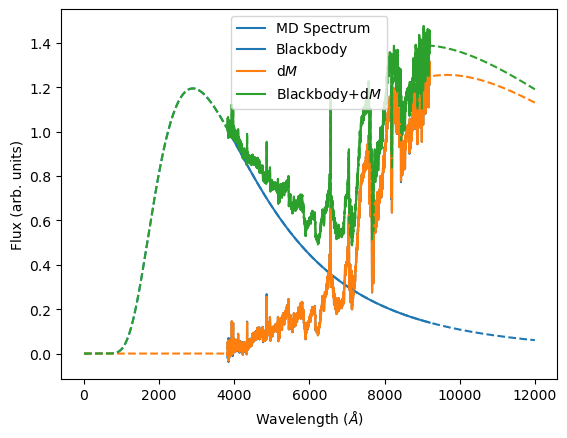

In [8]:

mdinterp = mdwarf_interp(ROOTDIR + quiescent_spectra[quiescent_spectrum], plotit=True)
md = mdinterp(WAVELENGTH)
amplitude = 1
res = scipy.optimize.minimize(fitbb_to_spec, [amplitude], args=(3000, md))
md[WAVELENGTH >= WMAX] = (make_bb(WAVELENGTH, 3000) * 1e27 * res.x)[WAVELENGTH >= WMAX]


bb = make_bb(WAVELENGTH, TEMP) * globals.BBnorm
md_bb = md + bb

def bb_fraction(md, T=10000, ff=globals.FF):
    bb = make_bb(WAVELENGTH, T) * globals.BBnorm
    ff = ff / globals.FF #makes ff = 1.0 by default
    md_bb = md + bb * ff
    return sed_integ(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX]*ff) / sed_integ(WAVELENGTH[WMIN:WMAX],md_bb[WMIN:WMAX])

#TEST:
result = bb_fraction(md)
print('Flux contribution of a flare corresponding to 10000K BB ' + quiescent_spectrum.upper() + ' spectrum with FF = 0.05. Expected = 0.5, Result = {}'.format(result))

#assert result == 0.5, "WARNING: FAILED NORMALIZATION TEST"

plt.plot(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX], c='C0', label='Blackbody')
plt.plot(WAVELENGTH[WMIN:WMAX], md[WMIN:WMAX], c='C1', label=r'd$M$')
plt.plot(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX]+md[WMIN:WMAX], c='C2', label=r'Blackbody+d$M$')
plt.legend();
plt.plot(WAVELENGTH, bb, c='C0', ls='--', label='Blackbody')
plt.plot(WAVELENGTH, md, c='C1', ls='--', label='d' + quiescent_spectrum.upper())
plt.plot(WAVELENGTH, bb+md, c='C2', ls='--', label='BB+d' + quiescent_spectrum.upper())
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux (arb. units)');
#plt.savefig('Figures/bb_calib.png', dpi=300, bbox_inches='tight');

In [9]:
#what is the fract of total MD flux + BB ff 5% if BB T = 5000, what is total flux contributed by BB?

print(sed_integ(WAVELENGTH, md), sed_integ(WAVELENGTH[WMIN:WMAX], 
                                           bb[WMIN:WMAX]), 
      sed_integ(WAVELENGTH[WMIN:WMAX], md_bb[WMIN:WMAX]))

5762.863644472597 2354.9463148098052 4709.8926296196105


In [10]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

colors = ['#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#4B3713']

In [11]:
#Generate extended dM spectrum:
MDSPEC = ROOTDIR + quiescent_spectra[quiescent_spectrum]
gen_mdspec(mdname=MDSPEC, filename='mdspec.npy', extended=True)

In [12]:
#Generate extended spectra for all SpT:
'''
for file in os.listdir('sdsstemplates'):

    mdinterp = mdwarf_interp(ROOT'sdsstemplates/' + file, plotit=False)

    md = mdinterp(WAVELENGTH)
    amplitude = 1
    res = scipy.optimize.minimize(fitbb_to_m5, [amplitude], args=(3000, md))
    md[WAVELENGTH >= WMAX] = (make_bb(WAVELENGTH, 3000) * 1e27 * res.x)[WAVELENGTH >= WMAX]

    np.save(file = '/Users/riley/Desktop/RAFTS/sdsstemplates/' + file[:-5] + '_ext', arr = md)
'''

"\nfor file in os.listdir('sdsstemplates'):\n\n    mdinterp = mdwarf_interp(ROOT'sdsstemplates/' + file, plotit=False)\n\n    md = mdinterp(WAVELENGTH)\n    amplitude = 1\n    res = scipy.optimize.minimize(fitbb_to_m5, [amplitude], args=(3000, md))\n    md[WAVELENGTH >= WMAX] = (make_bb(WAVELENGTH, 3000) * 1e27 * res.x)[WAVELENGTH >= WMAX]\n\n    np.save(file = '/Users/riley/Desktop/RAFTS/sdsstemplates/' + file[:-5] + '_ext', arr = md)\n"

(60.401802107370266, 82.6147467070432)

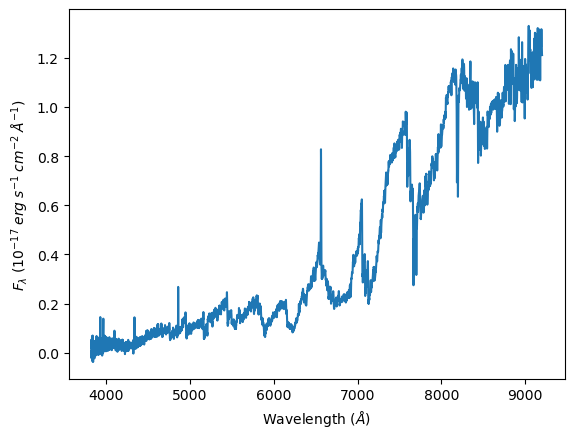

In [18]:
mdinterp = mdwarf_interp(ROOTDIR + quiescent_spectra[quiescent_spectrum], plotit=True)
md = mdinterp(WAVELENGTH)
np.save(quiescent_spectrum + '.npy', md)

weff = lamb_eff_md(band='g', temp=0, mdpath=quiescent_spectrum + '.npy')
dcr_offset(weff, airmass = 1.45), dcr_offset(weff, airmass = 1.75)


In [19]:
sun = pd.read_csv("sunspectrum.csv")
sun.iloc[:,0]

0        200.015
1        200.060
2        200.104
3        200.149
4        200.194
          ...   
2099    2377.185
2100    2382.716
2101    2388.265
2102    2393.784
2103    2399.011
Name: 2, Length: 2104, dtype: float64

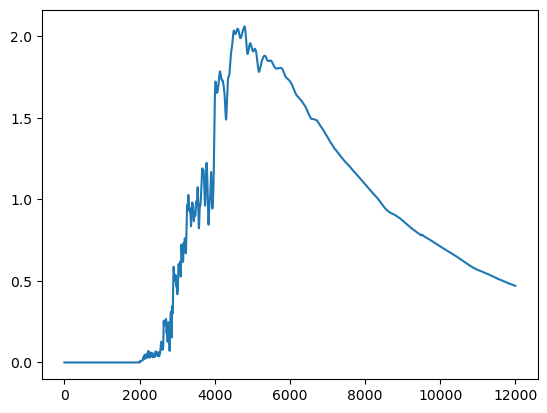

In [20]:
import scipy
sun_sp = scipy.interpolate.interp1d(sun.iloc[:,0].values * 10, sun.iloc[:,1].values, bounds_error=False, fill_value=0)(WAVELENGTH)
plt.plot(WAVELENGTH, sun_sp)
np.save(open("sun.npy", "wb"), sun_sp)
#sun_sp



In [21]:
import numpy as np
#calc_w_eff(sun_sp, filt_interp(band='g'), WAVELENGTH)
weff = lamb_eff_md(band='g', temp=0, mdpath=quiescent_spectrum + '.npy')

aidiff = []
weff_sun = lamb_eff_md(band='g', temp=0, mdpath='sun.npy')
for a in AM:
    aidiff.append((dcr_offset(weff_sun, airmass = a) - dcr_offset(weff_sun, airmass = AM[0])) - 
          (dcr_offset(weff, airmass = a) - dcr_offset(weff, airmass = AM[0])))
np.save(f"DCRsum_{quiescent_spectrum}.npy", np.array(aidiff))
aidiff

[0.0,
 0.00047558915540690805,
 0.0009509531732305732,
 0.001428842156578014,
 0.0019043372725846552,
 0.002386167140016937,
 0.002881719630558166,
 0.003370198171865013,
 0.0038695550708141013,
 0.004349611224043315,
 0.0048592709400878675,
 0.0053548763481714445,
 0.005855700855001089,
 0.006355220694580055,
 0.006857661722413866,
 0.007366407225724458,
 0.0078863069903079,
 0.008398607603972152,
 0.008912726130851922,
 0.009430582173983737,
 0.009949687200041524,
 0.010471066592664613,
 0.010994423341479376,
 0.011508186994227287,
 0.012037878705591254,
 0.012562981825460895,
 0.01310470408211728,
 0.013657897984451495,
 0.014206141628143598,
 0.014757392797626778,
 0.015297444259140036,
 0.015828406528065386,
 0.016367876276326854,
 0.01691295838202933,
 0.017471273022842126,
 0.0180400557546605,
 0.01859820835762349,
 0.0191557057527163,
 0.019735896376353423,
 0.02030278561095855,
 0.02087209695482528,
 0.02144886963716175,
 0.02202795390532941,
 0.022607756996031014,
 0.02319090

## New Composite Spectra using Davenport et al 2012

In [22]:
dmfull = pd.read_table(ROOTDIR + quiescent_spectrum + '_template.dat', comment='#', 
                       delim_whitespace=True, names=['wavelength', 'log_flux'], na_values=-99)

BB frac = 0.5000572769071517


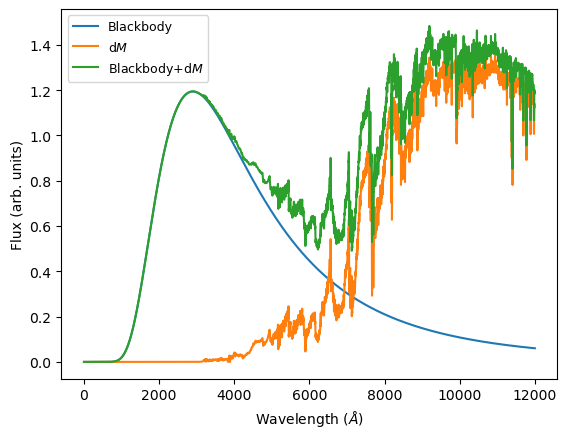

In [23]:
from scipy.interpolate.interpolate import interp1d
f = interp1d(dmfull['wavelength'] * 10000, 10**dmfull['log_flux'], bounds_error=False, fill_value=0.0)

md = f(WAVELENGTH)
md[np.isnan(md)] = 0.0

def fitbb_to_dmfull(a, dmspec):
    result = np.abs(bb_fraction(dmspec * a) - 0.5)
    return result

amplitude = 1 / md.max()
res = scipy.optimize.minimize(fitbb_to_dmfull, [amplitude], args=(md))
md *= res.x

bb = make_bb(WAVELENGTH, TEMP) * globals.BBnorm

md_bb = md + bb

#TEST:
result = bb_fraction(md)
print('BB frac = {}'.format(result))

np.save('mdspec_full.npy', md)

plt.plot(WAVELENGTH, bb, c='C0', label='Blackbody')
plt.plot(WAVELENGTH, md, c='C1', label=r'd$M$')
plt.plot(WAVELENGTH, bb+md, c='C2', label=r'Blackbody+d$M$')
plt.legend(fontsize = 9, loc = 'upper left');
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux (arb. units)')
plt.savefig('Figures/bb_calib.png', dpi=300, bbox_inches='tight');

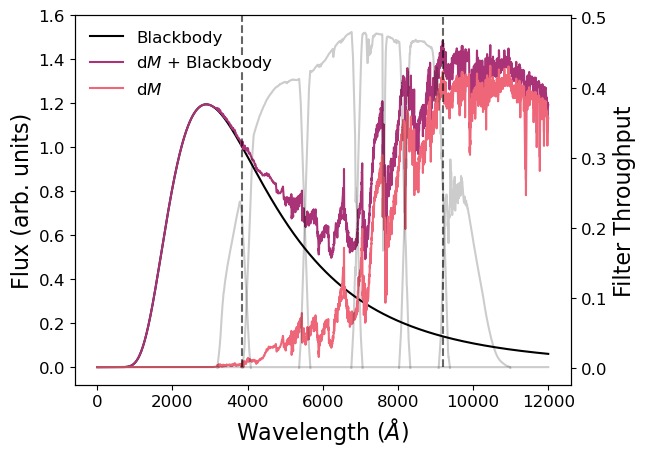

In [24]:
fig, ax = plt.subplots()

ax.plot(make_bb(WAVELENGTH, 10000) * globals.BBnorm, c='k', label='Blackbody')
ax.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm, c=colors[4],  label=r'd$M$ + Blackbody')
ax.plot(np.load('mdspec_full.npy'), c=colors[3], label=r'd$M$')

ax2 = ax.twinx()
ax2.set_ylabel('Filter Throughput', fontsize=16)
ax2.tick_params(axis ='y')
ax2.yaxis.set_tick_params(labelsize=12)

for band in filters:
    f = filt_interp(band)
    ax2.plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k', alpha=0.2)

ax.plot(WAVELENGTH, np.full_like(WAVELENGTH, 0.0), c='k', alpha=0.2)
ax.vlines(9200, 0, 1.6, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 0, 1.35, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 1.42, 1.6, color='k', ls='--', alpha=0.6)
ax.set_ylim(None, 1.6)
ax.legend(fontsize = 12, loc = 'upper left', frameon=False)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
ax.set_ylabel('Flux (arb. units)', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

fig.savefig('Figures/bb_calib.png', dpi=300, bbox_inches='tight');

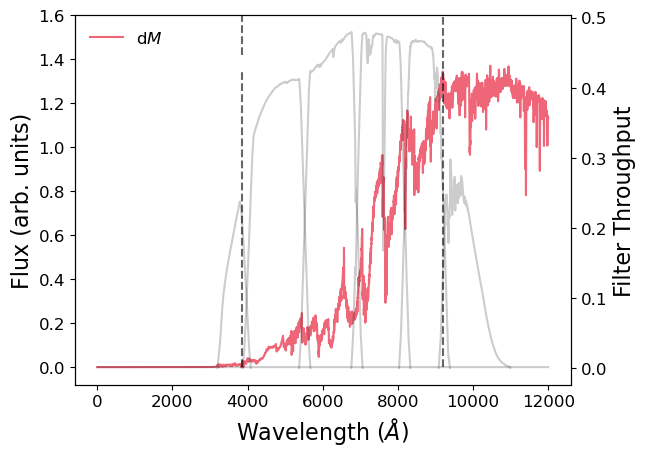

In [25]:
fig, ax = plt.subplots()

#ax.plot(make_bb(WAVELENGTH, 10000) * globals.BBnorm, c='k', label='Blackbody')
#ax.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm, c=colors[4],  label=r'd$M$ + Blackbody')
ax.plot(np.load('mdspec_full.npy'), c=colors[3], label=r'd$M$')

ax2 = ax.twinx()
ax2.set_ylabel('Filter Throughput', fontsize=16)
ax2.tick_params(axis ='y')
ax2.yaxis.set_tick_params(labelsize=12)

for band in filters:
    f = filt_interp(band)
    ax2.plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k', alpha=0.2)

ax.plot(WAVELENGTH, np.full_like(WAVELENGTH, 0.0), c='k', alpha=0.2)
ax.vlines(9200, 0, 1.6, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 0, 1.35, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 1.42, 1.6, color='k', ls='--', alpha=0.6)
ax.set_ylim(None, 1.6)
ax.legend(fontsize = 12, loc = 'upper left', frameon=False)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
ax.set_ylabel('Flux (arb. units)', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

fig.savefig('Figures/bb_calib_1.png', dpi=300, bbox_inches='tight');

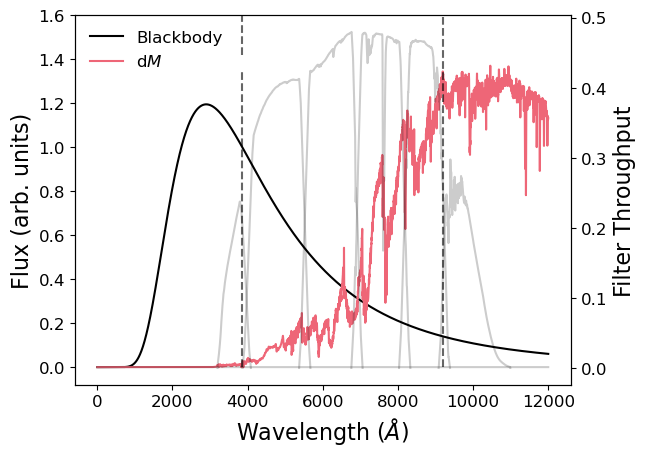

In [26]:
fig, ax = plt.subplots()

ax.plot(make_bb(WAVELENGTH, 10000) * globals.BBnorm, c='k', label='Blackbody')
#ax.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm, c=colors[4],  label=r'd$M$ + Blackbody')
ax.plot(np.load('mdspec_full.npy'), c=colors[3], label=r'd$M$')

ax2 = ax.twinx()
ax2.set_ylabel('Filter Throughput', fontsize=16)
ax2.tick_params(axis ='y')
ax2.yaxis.set_tick_params(labelsize=12)

for band in filters:
    f = filt_interp(band)
    ax2.plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k', alpha=0.2)

ax.plot(WAVELENGTH, np.full_like(WAVELENGTH, 0.0), c='k', alpha=0.2)
ax.vlines(9200, 0, 1.6, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 0, 1.35, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 1.42, 1.6, color='k', ls='--', alpha=0.6)
ax.set_ylim(None, 1.6)
ax.legend(fontsize = 12, loc = 'upper left', frameon=False)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
ax.set_ylabel('Flux (arb. units)', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

fig.savefig('Figures/bb_calib_2.png', dpi=300, bbox_inches='tight');

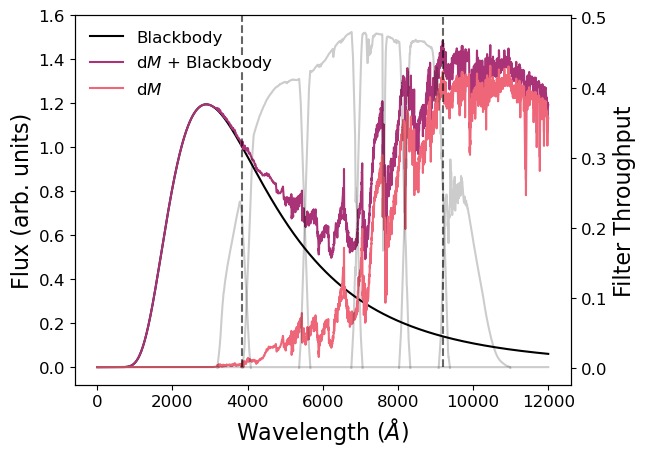

In [27]:
fig, ax = plt.subplots()

ax.plot(make_bb(WAVELENGTH, 10000) * globals.BBnorm, c='k', label='Blackbody')
ax.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm, c=colors[4],  label=r'd$M$ + Blackbody')
ax.plot(np.load('mdspec_full.npy'), c=colors[3], label=r'd$M$')

ax2 = ax.twinx()
ax2.set_ylabel('Filter Throughput', fontsize=16)
ax2.tick_params(axis ='y')
ax2.yaxis.set_tick_params(labelsize=12)

for band in filters:
    f = filt_interp(band)
    ax2.plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k', alpha=0.2)

ax.plot(WAVELENGTH, np.full_like(WAVELENGTH, 0.0), c='k', alpha=0.2)
ax.vlines(9200, 0, 1.6, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 0, 1.35, color='k', ls='--', alpha=0.6)
ax.vlines(3850, 1.42, 1.6, color='k', ls='--', alpha=0.6)
ax.set_ylim(None, 1.6)
ax.legend(fontsize = 12, loc = 'upper left', frameon=False)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
ax.set_ylabel('Flux (arb. units)', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

## Visualizations

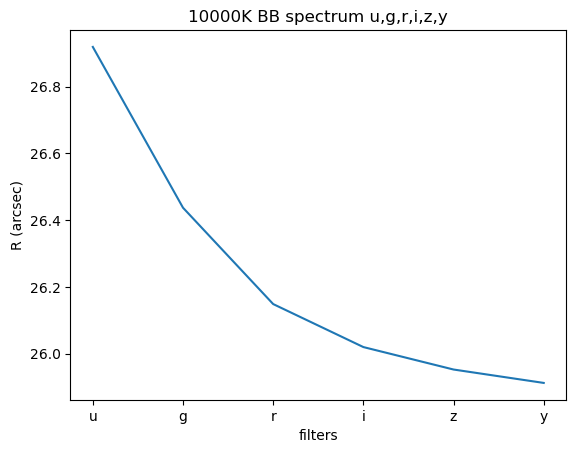

In [28]:
weff = np.array([lamb_eff_BB(band=f, temp=TEMP, verbose=False) for f in filters])
plt.plot(dcr_offset(weff, airmass = globals.airmass))
plt.xlabel("filters")
plt.ylabel("R (arcsec)")
plt.xticks(range(6), labels=["u","g","r","i","z","y"])
plt.title("{}K BB spectrum u,g,r,i,z,y".format(TEMP));

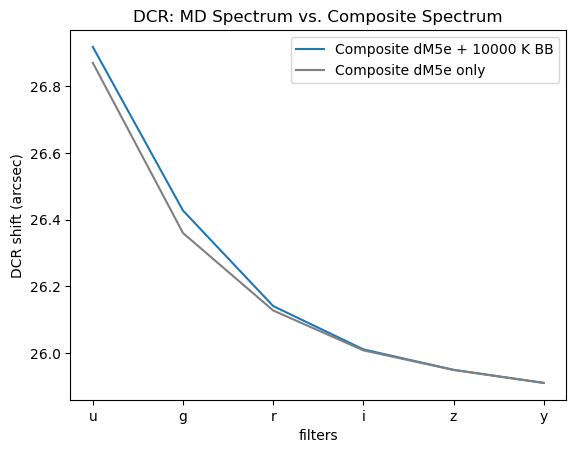

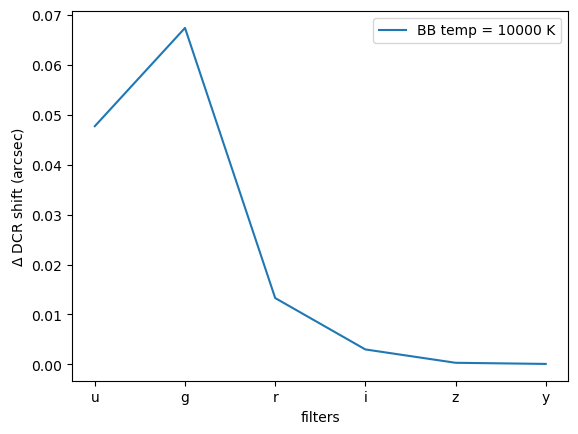

In [29]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

w_eff1 = np.array([lamb_eff_md(band=f, temp=0, mdpath='mdspec_full.npy') for f in filters])
w_eff2 = np.array([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy') for f in filters])

ax1.plot(dcr_offset(w_eff2, airmass = globals.airmass), label='Composite d' + quiescent_spectrum.upper() +'e + {} K BB'.format(TEMP))
ax1.plot(dcr_offset(w_eff1, airmass = globals.airmass), c='grey', label="Composite d" + quiescent_spectrum.upper() + "e only")

ax1.set_ylabel("DCR shift (arcsec)")
ax1.set_xlabel("filters")
ax1.set_xticks(range(6))
ax1.set_xticklabels(["u","g","r","i","z","y"])
ax1.set_title("DCR: MD Spectrum vs. Composite Spectrum")
ax1.legend()

ax2.plot(dcr_offset(w_eff2, airmass = globals.airmass) - dcr_offset(w_eff1, airmass = globals.airmass), label='BB temp = {} K'.format(TEMP))
ax2.set_ylabel(r"$\Delta$ DCR shift (arcsec)")
ax2.set_xlabel("filters")
ax2.set_xticks(range(6))
ax2.set_xticklabels(["u","g","r","i","z","y"])
ax2.legend()

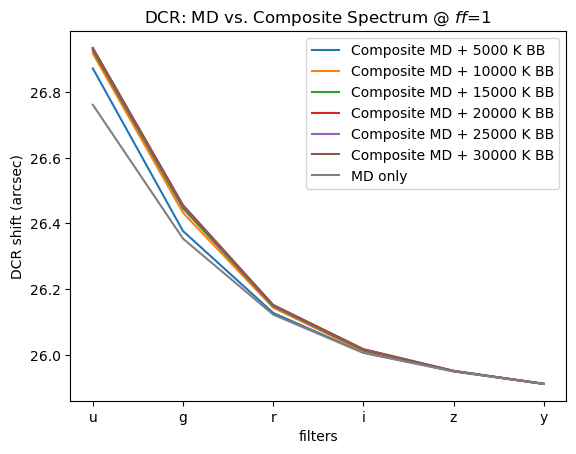

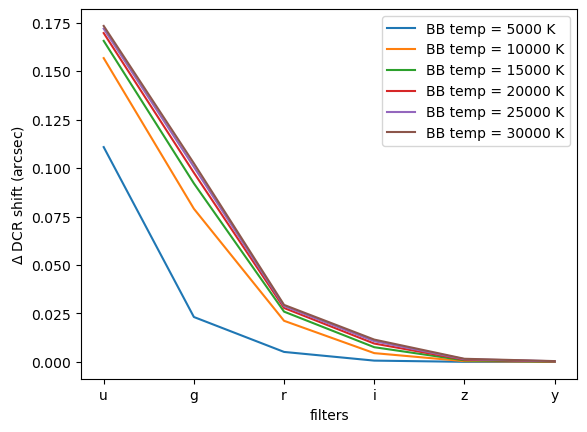

In [30]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

for temp in range(5000,35000,5000):

    w_eff1 = np.array([lamb_eff_md(band=f, temp=0) for f in filters])
    w_eff2 = np.array([lamb_eff_md(band=f, temp=temp) for f in filters])

    ax1.plot(dcr_offset(w_eff2, airmass = globals.airmass), label='Composite MD + {} K BB'.format(temp))
    ax2.plot(dcr_offset(w_eff2, airmass = globals.airmass) - dcr_offset(w_eff1, airmass = globals.airmass), label='BB temp = {} K'.format(temp))

ax1.plot(dcr_offset(w_eff1, airmass = globals.airmass), c='grey', label="MD only")
ax1.set_ylabel("DCR shift (arcsec)")
ax1.set_xlabel("filters")
ax1.set_xticks(range(6))
ax1.set_xticklabels(["u","g","r","i","z","y"])
ax1.set_title(r"DCR: MD vs. Composite Spectrum @ $ff$=1")
ax1.legend()


ax2.set_ylabel(r"$\Delta$ DCR shift (arcsec)")
ax2.set_xlabel("filters")
ax2.set_xticks(range(6))
ax2.set_xticklabels(["u","g","r","i","z","y"])
ax2.legend()

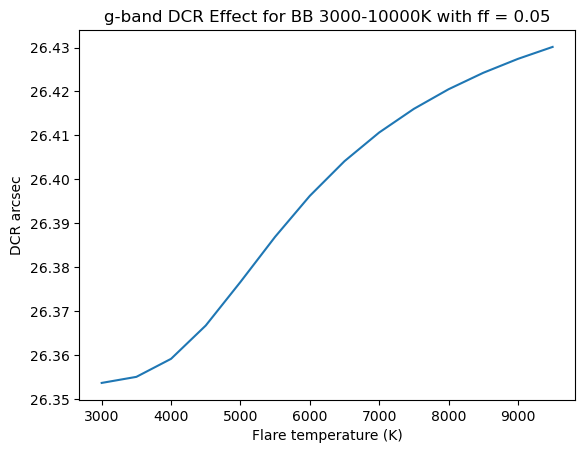

In [31]:
w_eff = np.array([lamb_eff_md(band='g', temp=t) for t in range(3000,10000,500)])
plt.plot(range(3000,10000,500), dcr_offset(w_eff, airmass = globals.airmass))
plt.ylabel("DCR arcsec")
plt.xlabel("Flare temperature (K)")
plt.title("g-band DCR Effect for BB 3000-10000K with ff = 0.05");

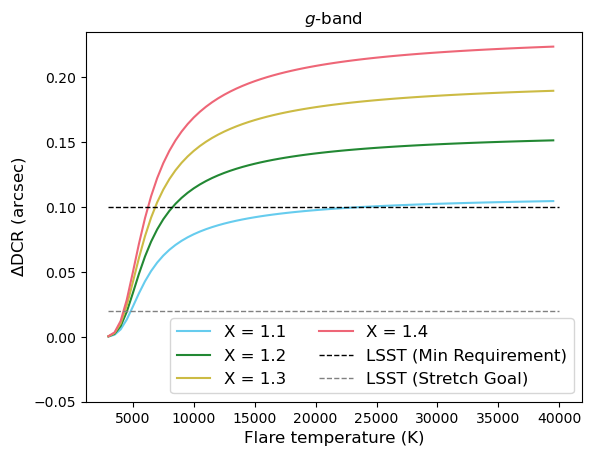

In [32]:
ams = [1.1,1.2,1.3,1.4]
temps = np.arange(3000,40000,500)

w_eff1 = np.array([lamb_eff_md(band='g', temp=0, ff=globals.FF) for t in temps])
w_eff2 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF) for t in temps])

for color, am in zip(colors,ams):
    plt.plot(temps, dcr_offset(w_eff2, airmass = am)-dcr_offset(w_eff1, airmass = am), c=color, label="X = {}".format(am))
    

plt.hlines(0.1, 3000, 40000, color='black', ls = '--', lw = 1, label = 'LSST (Min Requirement)')
plt.hlines(0.02, 3000, 40000, color='grey', ls = '--', lw = 1, label = 'LSST (Stretch Goal)')

plt.ylabel(r"$\Delta$DCR (arcsec)", fontsize=12)
plt.xlabel("Flare temperature (K)", fontsize=12)
plt.ylim(-0.05, None)
plt.title(r"$g$-band")
plt.legend(fontsize=12, loc='lower right', ncol=2)
plt.savefig('Figures/deltashifttemp_g.png', dpi=300, bbox_inches='tight')

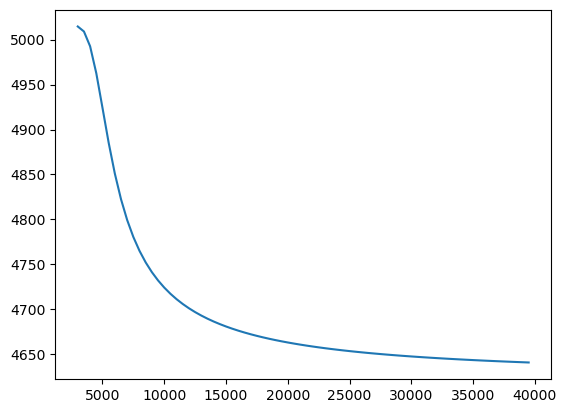

In [33]:
plt.plot(temps, np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF) for t in temps]))

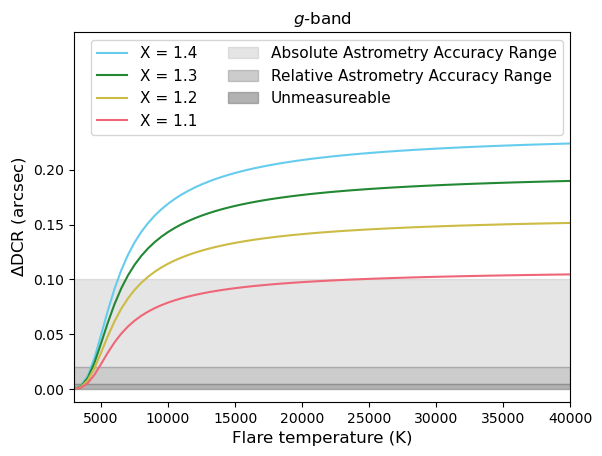

In [34]:
ams = [1.1,1.2,1.3,1.4]
temps = np.arange(3000,40500,500)

w_eff1 = np.array([lamb_eff_md(band='g', temp=0, ff=globals.FF) for t in temps])
w_eff2 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF) for t in temps])

for color, am in zip(colors,ams[::-1]):
    plt.plot(temps, dcr_offset(w_eff2, airmass = am)-dcr_offset(w_eff1, airmass = am), c=color, label="X = {}".format(am))
    

#plt.hlines(0.1, 3000, 40000, color='black', ls = '--', lw = 1, label = 'Minimum Requirement (Absolute)')
#plt.hlines(0.02, 3000, 40000, color='grey', ls = '--', lw = 1, label = 'Stretch Goal (Absolute)')
#plt.hlines(0.02, 3000, 40000, color='black', ls = '-.', lw = 1, label = 'Minimum Requirement (Relative)')
#plt.hlines(0.005, 3000, 40000, color='grey', ls = '-.', lw = 1, label = 'Stretch Goal (Relative)')

plt.fill_between(temps, 0.1, 0.02, color='grey', alpha=0.2, label='Absolute Astrometry Accuracy Range')
plt.fill_between(temps, 0.02, 0.005, color='grey', alpha=0.4, label='Relative Astrometry Accuracy Range')
plt.fill_between(temps, 0.005, 0.0, color='grey', alpha=0.6, label='Unmeasureable')

#plt.annotate("", xy=(5000, 0.2), xytext=(5000, 0.099), arrowprops=dict(arrowstyle="->", color='green', alpha=0.8, lw=2), fontsize=9)

plt.yticks(ticks = [0.20, 0.15, 0.10, 0.05, 0.00], labels=['0.20', '0.15', '0.10', '0.05', '0.00'])

plt.ylabel(r"$\Delta$DCR (arcsec)", fontsize=12)
plt.xlabel("Flare temperature (K)", fontsize=12)
plt.xlim(3000,40000)
plt.ylim(None, 0.325)
plt.title(r"$g$-band")
plt.legend(fontsize=11, loc='upper right', ncol=2)
plt.savefig('Figures/deltashifttemp_g.png', dpi=300, bbox_inches='tight')

### Temp vs Airmass Heatmap

In [35]:
#generate grid
bins = 20
grid = np.zeros([bins,bins])

ams = np.arange(1.05, 2.05, 0.05)
temps = np.arange(2000, 42000, 2000)

x = np.load('Notebooks/baseline3.0_am.npy')
y = np.load('Notebooks/ef3temps.npy')

for i, am in enumerate(ams):
    for j, temp in enumerate(temps):
        w_eff1 = np.array(lamb_eff_md(band='g', temp=0, ff=globals.FF))
        w_eff2 = np.array(lamb_eff_md(band='g', temp=temp, ff=globals.FF))
        grid[i][j] = dcr_offset(w_eff2, airmass = am) - dcr_offset(w_eff1, airmass = am)

FileNotFoundError: [Errno 2] No such file or directory: 'Notebooks/baseline3.0_am.npy'

In [ ]:
#Plotting
fig = plt.figure(figsize=(8,8))

fig.tight_layout()

gs = fig.add_gridspec(2, 2,  width_ratios=(4,1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax_img = fig.add_subplot(gs[1,0])
ax_boxh = fig.add_subplot(gs[0,0], sharex=ax_img)
ax_boxv = fig.add_subplot(gs[1,1], sharey=ax_img)
ax_cbar = fig.add_subplot(gs[0,1])

centers = [ams.min(),ams.max(),temps.max(),temps.min()]
dx, = np.diff(centers[:2])/(grid.shape[1]-1)
dy, = -np.diff(centers[2:])/(grid.shape[0]-1)
extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]
img = ax_img.imshow(grid, cmap='YlOrRd_r', interpolation='gaussian', extent=extent)
ax_img.hlines((np.median(y)-2000) / 2000, (1.05-1.05) / 0.05, (2.0-1.05) / 0.05, color='white', linestyles='--', label='Median')
ax_img.vlines((np.median(x)-1.05) / 0.05, (2000-2000) / 2000, (40000-2000) / 2000,  color='white', linestyles='--')
ax_img.hlines(np.median(y), 1.0, 2.0, color='white', linestyles='--')
ax_img.vlines(np.median(x), 0, 40000,  color='white', linestyles='--')

ax_img.set_xticks(np.arange(centers[0], centers[1]+dx, dx))
ax_img.set_yticks(np.arange(centers[3], centers[2]+dy, dy))

for label in ax_img.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

for label in ax_img.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax_img.set_position([0.1,0.1,0.625,0.625])
ax_img.set_aspect('auto')
ax_img.set_xlabel(r'Airmass ($X$)')
ax_img.set_ylabel('Flare Temperature (K)')
cbar = fig.colorbar(img, cax=ax_cbar)
cbar.set_label(r'$\Delta$DCR (arcsec)')
ax_img.legend(facecolor='k', labelcolor='white')

from scipy.stats import kurtosis
N = len(x)
N_bins = 1 + np.log2(N) + np.log2(1 + kurtosis(x) * np.sqrt(N / 6))

ax_boxh.hist(x, bins=int(N_bins), color='k', histtype='step')
ax_boxh.vlines(np.median(x), 0, 400000, color='orange')
ax_boxh.set_xlim(1.0 + dx / 2, 2.0)
ax_boxh.set_ylim(0,400000)
ax_boxh.xaxis.tick_top()
ax_boxh.set_ylabel(r'$N_{visits}$')
ax_boxh.set_xlabel('LSST Airmass Distribution (baseline_v3.0_10yrs)')
ax_boxh.xaxis.set_label_position('top')

for label in ax_boxh.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

ax_boxv.boxplot(y, vert=True)
ax_boxv.set_ylim(2000,40000)
ax_boxv.set_xticks([])
ax_boxv.yaxis.tick_right()
ax_boxv.invert_yaxis()
ax_boxv.set_ylabel(r'Peak Flare $T_{eff}$ (Howard et al. 2020)')
ax_boxv.yaxis.set_label_position('right')

for label in ax_boxv.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.savefig('Figures/temp_am_grid.png', dpi=300, bbox_inches='tight')


For an observed flare, given flare temp, given temp distribution (Howard et al.)

-observe a flare, assume some astrometric precision q

-A_crit(T) = critical airmass at T where deltaDCR > q

-$P(\Delta DCR) = P(airmass > A_{crit}(T) | T)$

In [ ]:
ams = np.arange(1.05, 3.05, 0.05)
temps = np.arange(2000, 40500, 500)
qs = [0.01,0.05,0.1,0.2]

for i, q in enumerate(qs):
    pdcr = []
    for temp in temps:
        ptemp = len(y[y >= temp]) / len(y)
        am_crit = dcr_offset_inverse(w_eff_1 = lamb_eff_md(band='g', temp=temp, ff=globals.FF),
                                     w_eff_0 = lamb_eff_md(band='g', temp=0, ff=globals.FF), dcr=q)
        
        pam = len(x[x > am_crit]) / len(x)
        ptotal = ptemp * pam
        pdcr.append(ptotal)
        if temp == 10000:
            print('P10k = {0:.3f}'.format(ptotal))
    plt.plot(temps, pdcr, color=colors[i], label=r'$q$ = {}"'.format(q))

plt.ylabel(r'$P(X > X_{crit}\;|\;T_{eff} > T)$', fontsize=14)
plt.xlabel(r'Temperature (K)', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=14)
plt.savefig('Figures/dcr_prob.png', dpi=300, bbox_inches='tight')

Other baselines:

In [36]:
baselines = pd.read_csv(ROOTDIR + 'baselines_airmasses.csv', usecols=[1,2,3,4,5])
baselines.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fbianco/RAFTS/baselines_airmasses.csv'

In [37]:
ams = np.arange(1.05, 3.05, 0.05)
temps = np.arange(2000, 40500, 500)
q = 0.05

for i, col in enumerate(baselines.columns):
    pdcr = []
    for temp in temps:
        ptemp = len(y[y >= temp]) / len(y)
        am_crit = dcr_offset_inverse(w_eff_1 = lamb_eff_md(band='g', temp=temp, ff=globals.FF),
                                     w_eff_0 = lamb_eff_md(band='g', temp=0, ff=globals.FF), dcr=q)
        
        pam = len(baselines[col].values[baselines[col].values > am_crit]) / len(baselines[col].values)
        ptotal = ptemp * pam
        pdcr.append(ptotal)
        if temp == 10000:
            print('P10k = {0:.3f}'.format(ptotal))

    #if col == 'baseline_v3.0':
        #plt.fill_between(temps, pdcr, np.zeros_like(pdcr), alpha=0.5)
    plt.plot(temps, pdcr, label='{}'.format(col))
    
    if i == 0:
        plt.fill_between(temps, pdcr, color='steelblue', alpha=0.6)

plt.ylabel(r'$P(X > X_{crit}\;|\;T_{eff} > T)$', fontsize=14)
plt.xlabel(r'Temperature (K)', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
#plt.title('q = {}'.format(q))
plt.legend(fontsize=14)
plt.savefig('Figures/dcr_prob_2.0.png', dpi=300, bbox_inches='tight')

NameError: name 'baselines' is not defined

### Total DCR Plots

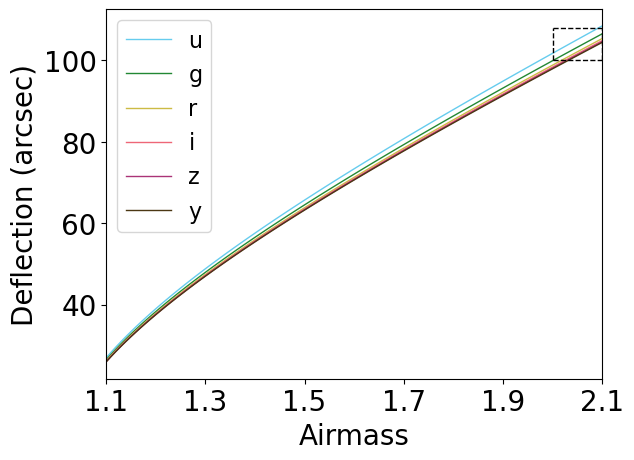

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

ams = np.arange(1.1,2.11,0.01)

for b in filters:
    w_eff = np.array(lamb_eff_BB(band=b, temp=10000))
    plt.plot(ams, dcr_offset(w_eff, airmass = ams), color=filtercolors[b], lw=1, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 6))
plt.tick_params(labelsize=20)
ax.vlines([2.0, 2.1], 100, 108, color='k', lw=1, ls='--')
ax.hlines([100, 108], 2.0, 2.1, color='k', lw=1, ls='--')
plt.xlabel('Airmass', fontsize=20)
plt.ylabel('Deflection (arcsec)', fontsize=20)
plt.legend(fontsize=16, loc='upper left')
plt.savefig('Figures/better_dcrfig_0.png', dpi=300, bbox_inches='tight')

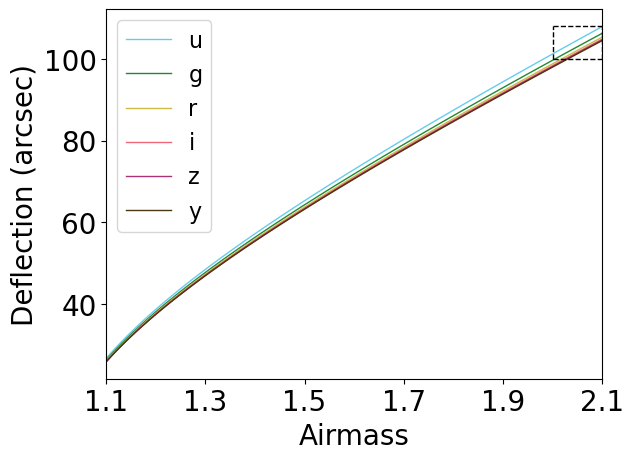

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

ams = np.arange(1.1,2.11,0.01)

for b in filters:
    w_eff = np.array(lamb_eff_md(band=b, temp=0))
    plt.plot(ams, dcr_offset(w_eff, airmass = ams), color=filtercolors[b], lw=1, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 6))
plt.tick_params(labelsize=20)
ax.vlines([2.0, 2.1], 100, 108, color='k', lw=1, ls='--')
ax.hlines([100, 108], 2.0, 2.1, color='k', lw=1, ls='--')
plt.xlabel('Airmass', fontsize=20)
plt.ylabel('Deflection (arcsec)', fontsize=20)
plt.legend(fontsize=16, loc='upper left')

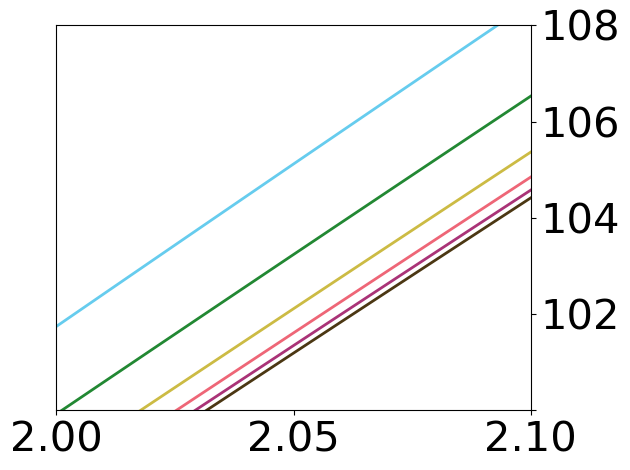

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

ams = np.arange(2.0,2.1,0.01)

for b in filters:
    w_eff = np.array(lamb_eff_BB(band=b, temp=10000))
    plt.plot(ams, dcr_offset(w_eff, airmass = ams), color=filtercolors[b], lw=2, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 3))
plt.ylim(100,108)
ax.yaxis.tick_right()
plt.tick_params(labelsize=30)
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.tight_layout()
plt.savefig('Figures/better_dcrfig_1.png', dpi=300)


### Astrometric Error plots

In [41]:
def dcr_curve(temps, band, airmass):

    w_eff1 = np.array([lamb_eff_md(band=band, temp=0, ff=globals.FF) for t in temps])
    w_eff2 = np.array([lamb_eff_md(band=band, temp=t, ff=globals.FF) for t in temps])

    ddcr = dcr_offset(w_eff2, airmass = airmass) - dcr_offset(w_eff1, airmass = airmass)

    return ddcr

In [42]:
def errorplot(testtemps, band, airmass):

    temps = range(3000,60000,500)
    testtemps = [5000, 10000, 25000]
    curve = dcr_curve(temps, band, airmass)

    plt.plot(temps, curve)

    for testtemp in testtemps:
        curvetest = dcr_curve([testtemp], band, airmass)
        lower = curvetest - 0.05
        upper = curvetest + 0.05
        xerr_lower = temps[np.where(curve == curve[min(range(len(curve)), key = lambda i: abs(curve[i] - lower))])[0][0]]
        xerr_upper = temps[np.where(curve == curve[min(range(len(curve)), key = lambda i: abs(curve[i] - upper))])[0][0]]
        print('Flare temp = {0}K: Upper error bound = {1}K, lower error bound = {2}K'.format(testtemp, xerr_upper, xerr_lower))
        plt.errorbar(testtemp, curvetest, yerr = 0.05, xerr = [[testtemp - xerr_lower], [xerr_upper - testtemp]], marker='o', capsize=3)

    plt.ylabel(r"$\Delta$ DCR shift (arcsec)")
    plt.xlabel("Flare temperature (K)")
    plt.title('{0}-band, airmass={1}'.format(band, airmass));

Flare temp = 5000K: Upper error bound = 6000K, lower error bound = 4500K
Flare temp = 10000K: Upper error bound = 59500K, lower error bound = 6000K
Flare temp = 25000K: Upper error bound = 59500K, lower error bound = 8000K


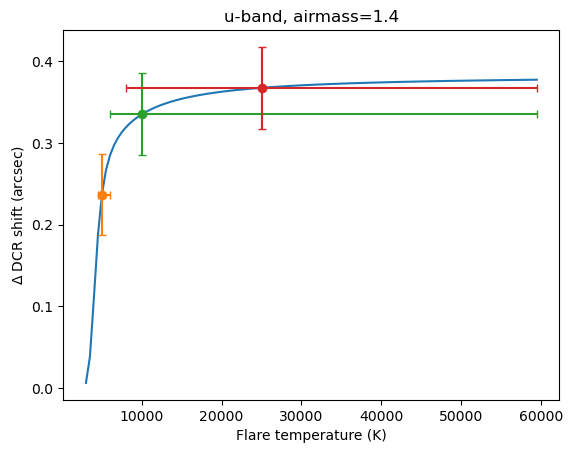

In [43]:
errorplot(testtemps=[5000, 10000, 25000], band='u', airmass=1.4)

Flare temp = 5000K: Upper error bound = 6000K, lower error bound = 3000K
Flare temp = 10000K: Upper error bound = 30000K, lower error bound = 7000K
Flare temp = 25000K: Upper error bound = 59500K, lower error bound = 9500K


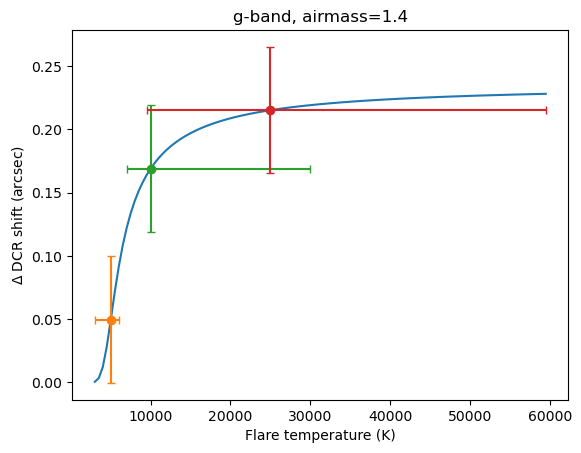

In [44]:
errorplot(testtemps=[5000, 10000, 25000], band='g', airmass=1.4)

Flare temp = 5000K: Upper error bound = 5500K, lower error bound = 4500K
Flare temp = 10000K: Upper error bound = 12500K, lower error bound = 8500K
Flare temp = 25000K: Upper error bound = 59500K, lower error bound = 15500K


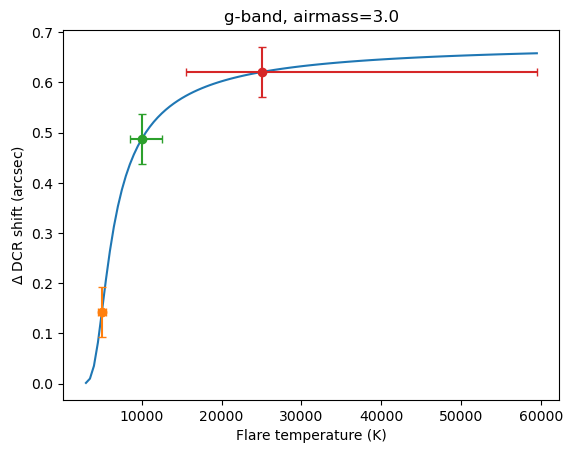

In [45]:
errorplot(testtemps=[5000, 10000, 25000], band='g', airmass=3.0)

### Filter-airmass Gridplots

In [46]:
def makegrid(temp, ff, ams, delta=False):

    grid = np.zeros((6,6))

    ams = ams

    if delta:
        for i, am in enumerate(ams):
            for j, f in enumerate(filters):
                w_eff1 = lamb_eff_md(band=f, temp=0, ff=ff, mdpath='mdspec_full.npy') 
                w_eff2 = lamb_eff_md(band=f, temp=temp, ff=ff, mdpath='mdspec_full.npy') 
                grid[i][j] = dcr_offset(w_eff2, airmass=am) - dcr_offset(w_eff1,airmass=am)

    else:
        for i, am in enumerate(ams):
            for j, f in enumerate(filters):
                w_eff = lamb_eff_md(band=f, temp=temp, ff=ff) 
                grid[i][j] = dcr_offset(w_eff, airmass=am)

    return grid

In [47]:
#Generate grids
temp, ff = 10000, globals.FF
grid = makegrid(temp, ff, AMS)
deltagrid = makegrid(temp, ff, AMS, delta=True)

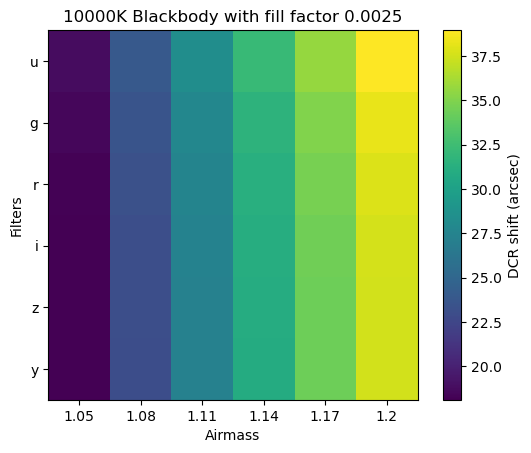

In [48]:
fig3, ax3 = plt.subplots(1,1)

c = ax3.imshow(grid.T)

ax3.set_xticks(range(6))
ax3.set_xticklabels(np.round(AMS, decimals=2))
ax3.set_yticks(range(6))
ax3.set_yticklabels(["u","g","r","i","z","y"])
ax3.set_ylabel("Filters")
ax3.set_xlabel("Airmass")
ax3.set_title('{0}K Blackbody with fill factor {1}'.format(temp, ff))

cbar = fig3.colorbar(c)
cbar.set_label('DCR shift (arcsec)', rotation=90)


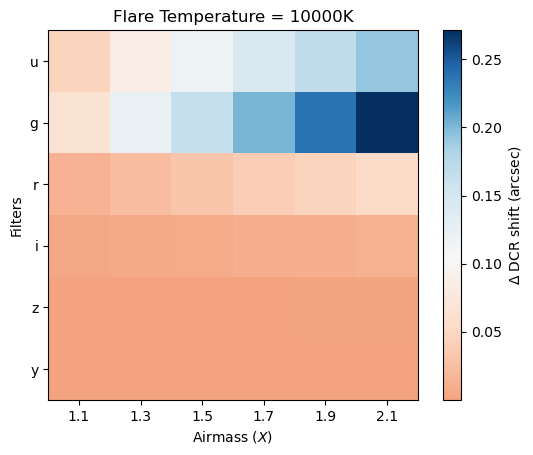

In [49]:
#Generate grids
temp, ff = 10000, globals.FF
AMS = np.linspace(1.1,2.1,6)
deltagrid = makegrid(temp, ff, AMS, delta=True)

q = 0.1
start = 0.3
mp = (q / (deltagrid.max() - deltagrid.min())) + start

orig_cmap = matplotlib.cm.RdBu
shifted_cmap = shiftedColorMap(orig_cmap, start=start, midpoint=mp, name='shifted')

fig3, ax3 = plt.subplots(1,1)

#c = ax3.imshow(deltagrid.T, cmap='Blues', norm=colors.LogNorm(vmin=0.01, vmax=0.4))
c = ax3.imshow(deltagrid.T, cmap=shifted_cmap)

ax3.set_xticks(range(6))
ax3.set_xticklabels(np.round(AMS, decimals=2))
ax3.set_yticks(range(6))
ax3.set_yticklabels(["u","g","r","i","z","y"])
ax3.set_ylabel("Filters")
ax3.set_xlabel(r"Airmass ($X$)")
ax3.set_title('Flare Temperature = {0}K'.format(temp))

cbar = fig3.colorbar(c)
cbar.set_label(r'$\Delta$ DCR shift (arcsec)', rotation=90)

plt.savefig('Figures/deltagridlog{}.png'.format(temp), dpi=300, bbox_inches='tight')

NameError: name 'x' is not defined

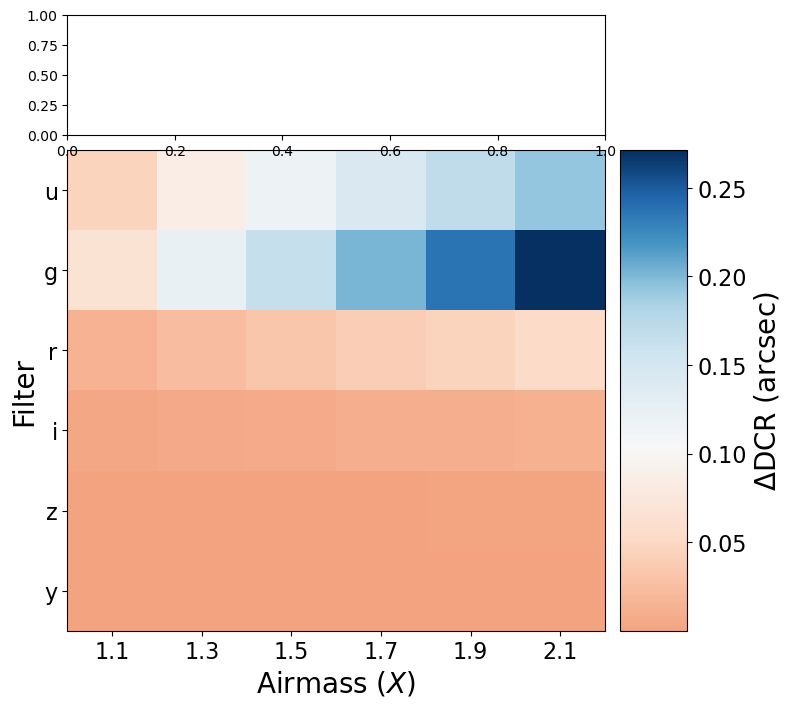

In [50]:
#Plotting
fig = plt.figure(figsize=(8,8))

fig.tight_layout()

gs = fig.add_gridspec(2, 2,  width_ratios=(8,1), height_ratios=(1, 4),
                      wspace=0.05, hspace=0.05)

ax_img = fig.add_subplot(gs[1,0])
ax_boxh = fig.add_subplot(gs[0,0])
ax_cbar = fig.add_subplot(gs[1,1])

centers = [AMS.min(),AMS.max(), 0, 6]
dx, = np.diff(centers[:2])/(grid.shape[1]-1)
dy, = -np.diff(centers[2:])/(grid.shape[0]-1)
extent = [0, 6, 0, 6]

orig_cmap = matplotlib.cm.RdBu
shifted_cmap = shiftedColorMap(orig_cmap, start=start, midpoint=mp, name='shifted')

img = ax_img.imshow(deltagrid.T, cmap=shifted_cmap, extent=extent)
ax_img.set_xticks(np.arange(6)+0.5)
ax_img.set_xticklabels(np.round(AMS, decimals=2), fontsize=16)
ax_img.set_yticks(np.arange(6) + 0.5)
ax_img.set_yticklabels(list(reversed(["u","g","r","i","z","y"])), fontsize=16)

#ax_img.set_position([0.1,0.1,0.625,0.625])
ax_img.set_aspect('auto')
ax_img.set_xlabel(r'Airmass ($X$)', fontsize=20)
ax_img.set_ylabel('Filter', fontsize=20)
cbar = fig.colorbar(img, cax=ax_cbar)
cbar.set_label(r'$\Delta$DCR (arcsec)', fontsize=20)
cbar.ax.tick_params(labelsize=16) 

from scipy.stats import kurtosis
N = len(x)
N_bins = 1 + np.log2(N) + np.log2(1 + kurtosis(x) * np.sqrt(N / 6))

ax_boxh.hist(x, bins=int(N_bins), color='k', histtype='step')
ax_boxh.vlines(np.median(x), 0, 410000, color='orange')
ax_boxh.set_xticks(np.round(AMS, decimals=2))
ax_boxh.set_xticklabels(np.round(AMS, decimals=2))
ax_boxh.set_xlim(1.0, 2.2)
ax_boxh.set_ylim(1,410000)
ax_boxh.xaxis.tick_top()
ax_boxh.set_ylabel(r'$N_{visits}$', fontsize=20)
ax_boxh.set_xticklabels(ax_boxh.get_xticklabels(), fontsize=16)
ax_boxh.set_yticklabels(ax_boxh.get_yticklabels(), fontsize=16)
ax_boxh.set_xlabel('LSST Airmass Distribution (baseline_v3.0_10yrs)', fontsize=20, labelpad=10)
ax_boxh.xaxis.set_label_position('top')
ax_boxh.yaxis.set_label_position('right')
ax_boxh.yaxis.tick_right()
plt.savefig('Figures/deltagridlog{}_whist.png'.format(temp), dpi=300, bbox_inches='tight')

## Making a cartoon DCR gif

In [51]:
#Simmed dDCR shift plot

np.random.seed(11037) 

#Invoke DCR machinery
temps = np.arange(3000,20000,500)
w_eff1 = np.array([lamb_eff_md(band='g', temp=0.0, ff=globals.FF) for t in temps])
w_eff2 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF) for t in temps])
dcrs = dcr_offset(w_eff2, airmass = 1.4)-dcr_offset(w_eff1, airmass = 1.4)

#Init positions
ra_pos = np.random.normal(0.0,0.1,size=50)
dec_pos = np.random.normal(0.0,0.1,size=50)

#Plotting
for temp, dcr in zip(temps, dcrs):

    #Update positions
    ra_pos += np.random.normal(0.0,0.01,size=len(ra_pos))
    dec_pos += np.random.normal(0.0,0.01,size=len(dec_pos))

    #Update flr star position
    flr_ra_pos = 0.1 + dcr * (1/np.sqrt(2)) + np.random.normal(0.0,0.01,size=1)[0]
    flr_dec_pos = 0.1 + dcr * (1/np.sqrt(2)) + np.random.normal(0.0,0.01,size=1)[0]
 
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(ra_pos, dec_pos, alpha=0.75)
    ax.scatter(flr_ra_pos, flr_dec_pos, color='red', s=100, marker='*', label='Flare star')

    ax.plot([0,2],[0,2], c='gray',ls='--', label="to zenith")

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')


    ax.set_xlabel(r"$\Delta$ RA (arcsec)", labelpad=150)
    ax.set_ylabel(r"$\Delta$ Dec (arcsec)", labelpad=150)
    ax.set_xticks([-0.4,-0.2,0.2,0.4])
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(-0.5,0.5)
    ax.set_title("Flare temp: {0}K, Airmass = {1}".format(temp, 1.4))
    ax.legend()
    ax.grid(False)

    fig.gca().set_aspect('equal')
    fig.savefig('Figures/sim_gif_figs/{}Ksim.png'.format(temp),dpi=300,bbox_inches='tight')
    plt.close()

## Effects on PSF 

Let's examine how the PSF is affected by both DCR and chromatic seeing as we move across the passband

Paper I Fig. 14 not produced here, see: https://colab.research.google.com/drive/1h0jn4IPO-aCtBw3eSQP_0zIRYNwb8rcr

In [52]:
'''
### Make quiescent and flaring PSFs for an input temp, airmass, etc

#set constants
size = 4000
pixscale = 0.01 #arcsec/pixel
fwhm = 0.7 / pixscale #0.7" seeing 
temp = 10000
am_i = 1 / np.cos(np.deg2rad(35))
am_f = 1 / np.cos(np.deg2rad(25))
band= 'g'
flux_factor = 1.5
f = filt_interp(band)


#import spectra
iSED = np.load('mdspec_full.npy')
fSED = np.load('mdspec_full.npy') + make_bb(WAVELENGTH, temp) * globals.BBnorm


#DCR First moment
def Rbar(SED, am):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    weff = np.exp(np.sum(p * np.log(WAVELENGTH[f(WAVELENGTH) > 0])) / np.sum(p))
    R = dcr_offset(weff, airmass = am) 
    
    return np.sum(p * R) / np.sum(p), weff

Rbar_i, weff_i = Rbar(iSED, am_i)
Rbar_f, weff_f = Rbar(fSED, am_f)
dRbar = Rbar_f - Rbar_i
print(Rbar_i, Rbar_f)
#DCR Second moment
def V(SED, am):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    R = dcr_offset(WAVELENGTH[f(WAVELENGTH) > 0], airmass=am)
    Rbar = np.sum(p * R) / np.sum(p)

    return np.sum(p * (R-Rbar)**2) / np.sum(p)

V_i = V(iSED, am_i)
V_f = V(fSED, am_f)
dV = V_f - V_i

#Make Gaussians
psf_i = create_2d_gaussian(size, fwhm_x = fwhm, fwhm_y = fwhm)
psf_f = create_2d_gaussian(size, fwhm_x = fwhm * (weff_f/weff_i)**(-2/5), fwhm_y = fwhm * (weff_f/weff_i)**(-2/5) + dV, center=((size/2),(size/2 - (dRbar / pixscale)))) * flux_factor

print('R = {0:.3f}", {1:.3f} pixels'.format(dRbar, dRbar / pixscale))
print('delta V = {0:.3f}", {1:.3f} pixels'.format(dV * pixscale, dV))
print('relative PSF size: ',(weff_f/weff_i)**(-2/5))

#Plotting
fig, ax = plt.subplots(1,4, figsize=(20,5))
vrange = (0,2)
a = ax[0].imshow(psf_i, vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
b = ax[1].imshow(psf_f,  vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
c = ax[2].imshow(psf_f - psf_i, vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')

ax[3].plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k')
ax[3].plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0] * iSED[f(WAVELENGTH) > 0.0], c=colors[3], label='Quiescent')
ax[3].plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0] * fSED[f(WAVELENGTH) > 0.0], c=colors[4], label='Flaring')
ax[3].fill_between(x = WAVELENGTH[f(WAVELENGTH) > 0.0], y1 = f(WAVELENGTH)[f(WAVELENGTH) > 0.0], 
                   where = (WAVELENGTH[f(WAVELENGTH) > 0.0] < weff_i) & (WAVELENGTH[f(WAVELENGTH) > 0.0] > weff_f), color='k', alpha=0.0)

x = WAVELENGTH[f(WAVELENGTH) > 0.0]
yg = f(WAVELENGTH)[f(WAVELENGTH) > 0.0]
yi = yg * iSED[f(WAVELENGTH) > 0.0]
yf = yg * fSED[f(WAVELENGTH) > 0.0]

ax[3].vlines(x=[weff_i, weff_f], ymin=[0,0], ymax = [yg[x == round(weff_i)], yg[x == round(weff_f)]], linestyle='--', color=[colors[3], colors[4]], alpha=0.8) 

ax[0].set_title('Quiescent, X = {0:.2f}'.format(am_i))
ax[1].set_title('Flaring, X = {0:.2f}'.format(am_f))
ax[2].set_title('Difference')
ax[3].set_title('band = {}; T = {}K; X = {}'.format(band, temp, am))
ax[3].set_xlabel(r'$\lambda$ $(\AA)$')
ax[3].set_ylabel('Arb. Flux')
ax[3].legend(loc='upper left', fontsize=8)

#Grid
for axis in ax.flatten()[:-1]:
    axis.set_xticks(np.arange(0,size,20))
    axis.set_yticks(np.arange(0,size,20))
    axis.set_xlim(0,size-2)
    axis.set_ylim(size-2,0)
    for tick in axis.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in axis.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    axis.grid(True, alpha=0.4)

cbar_ax = fig.add_axes([0.25, 0.05, 0.32, 0.05])
fig.colorbar(a, cax=cbar_ax, label='Relative flux', orientation='horizontal')

ax[0].annotate('zenith', xy = (size * 1/10, size * 2/5), xytext=(size * 1/10, size * 3/5), horizontalalignment='center', color='white',
    arrowprops = dict(facecolor='white', color='white', width=2, headwidth=6))

ax[3].annotate('', xytext = (weff_i,0.2), xy=(weff_f,0.2), horizontalalignment='center', color='white',
arrowprops = dict(facecolor='white', color='k', width=2, headwidth=6));

fig.savefig('Figures/psfshift2.png', dpi=300, bbox_inches='tight')
'''

'\n### Make quiescent and flaring PSFs for an input temp, airmass, etc\n\n#set constants\nsize = 4000\npixscale = 0.01 #arcsec/pixel\nfwhm = 0.7 / pixscale #0.7" seeing \ntemp = 10000\nam_i = 1 / np.cos(np.deg2rad(35))\nam_f = 1 / np.cos(np.deg2rad(25))\nband= \'g\'\nflux_factor = 1.5\nf = filt_interp(band)\n\n\n#import spectra\niSED = np.load(\'mdspec_full.npy\')\nfSED = np.load(\'mdspec_full.npy\') + make_bb(WAVELENGTH, temp) * globals.BBnorm\n\n\n#DCR First moment\ndef Rbar(SED, am):\n    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]\n    weff = np.exp(np.sum(p * np.log(WAVELENGTH[f(WAVELENGTH) > 0])) / np.sum(p))\n    R = dcr_offset(weff, airmass = am) \n    \n    return np.sum(p * R) / np.sum(p), weff\n\nRbar_i, weff_i = Rbar(iSED, am_i)\nRbar_f, weff_f = Rbar(fSED, am_f)\ndRbar = Rbar_f - Rbar_i\nprint(Rbar_i, Rbar_f)\n#DCR Second moment\ndef V(SED, am):\n    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]\n    R = dcr_offset(WAVELENGTH[f(WAVELENGTH)

## Reproducing DMTN-037 Fig 3

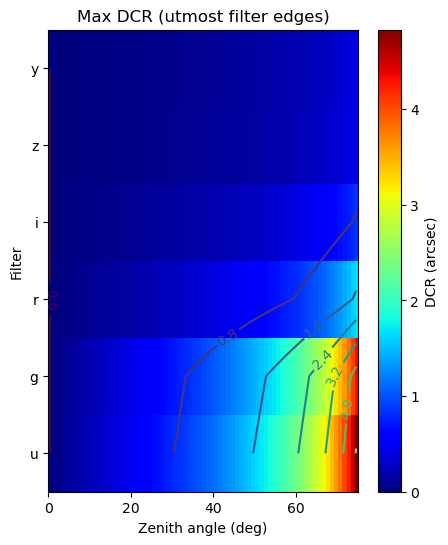

In [53]:
band_edges = {}

for band in filters:

    bandf = filt_interp(band)(WAVELENGTH)
    maxpt = np.where(bandf == bandf.max())[0][0]

    band_edges[band] = (WAVELENGTH[bandf == bandf[(bandf > 0) * (WAVELENGTH < maxpt)].min()][0], 
                        WAVELENGTH[bandf == bandf[(bandf > 0) * (WAVELENGTH > maxpt)].min()][0])

z = np.arange(0,75,1)

laserplot = np.zeros((len(band_edges), len(z)))

for i, z in enumerate(z):
    for j, band in enumerate(band_edges):
        laserplot[j][i] = dcr_offset(w_eff = band_edges[band][0], airmass = 1 / np.cos(np.deg2rad(z))) - \
                          dcr_offset(w_eff = band_edges[band][1], airmass = 1 / np.cos(np.deg2rad(z)))

fig, ax = plt.subplots(figsize=(5,6))
p = ax.imshow(laserplot, cmap='jet', origin='lower', extent=[0,75,6,0],aspect='auto')
c = ax.contour(laserplot, extent=[0,75,6,0], origin='lower', aspect='auto')

ax.set_yticks(np.arange(0,6) + 0.5)
ax.set_yticklabels(['y','z','i','r','g','u'])
ax.set_xlabel('Zenith angle (deg)')
ax.set_ylabel('Filter')
ax.set_title(r'Max DCR (utmost filter edges)')
ax.clabel(c, c.levels, inline=True, fontsize=10)

fig.colorbar(p, label=r'DCR (arcsec)')

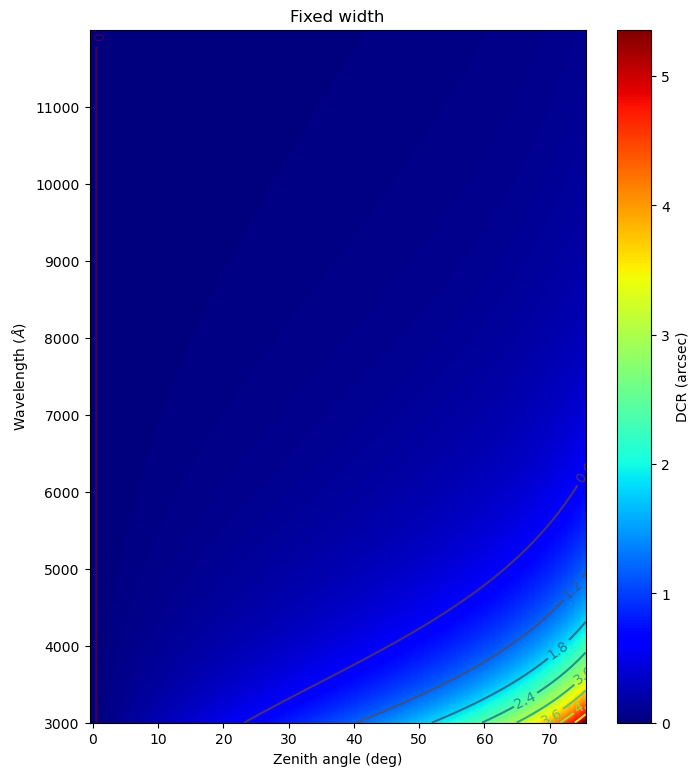

In [54]:
width = 700
wave = np.arange(3000, 12000, 1)
z = np.arange(0,76,1)

laserplot = np.zeros((len(wave), len(z)))

for i, z in enumerate(z):

    for j, w in enumerate(wave):

        laserplot[j][i] = dcr_offset(w_eff = w, airmass = 1 / np.cos(np.deg2rad(z))) - \
                          dcr_offset(w_eff = w + width, airmass = 1 / np.cos(np.deg2rad(z)))

fig, ax = plt.subplots(figsize=(8,9))
p = ax.imshow(laserplot, cmap='jet', origin='lower',aspect='auto')
c = ax.contour(laserplot, origin='lower', levels=np.arange(0, laserplot.max(), 0.6), aspect='auto')

ax.set_xlabel('Zenith angle (deg)')
ax.set_ylabel(r'Wavelength ($\AA$)')
ax.set_title(r"Fixed width")
ax.set_yticks(np.arange(0, len(wave), 1000))
ax.set_yticklabels(wave[::1000])
ax.clabel(c, c.levels, inline=True, fontsize=10)

fig.colorbar(p, label=r'DCR (arcsec)')

In [55]:
'''
band_edges_spec = {'u':(3000,4500), 
              'g':(4000, 5520), 
              'r':(5520, 6910),
              'i':(6910, 8180),
              'z':(8180,9220),
              'y':(9480, 10600)}
'''
band_edges_spec = {'u':(3200,4000), 
              'g':(4000, 5520), 
              'r':(5520, 6910),
              'i':(6910, 8180),
              'z':(8180,9220),
              'y':(9500, 10800)}

In [56]:
band_edges

{'u': (3200, 4086),
 'g': (3864, 5670),
 'r': (5370, 7060),
 'i': (6760, 8330),
 'z': (8030, 9386),
 'y': (9084, 10990)}

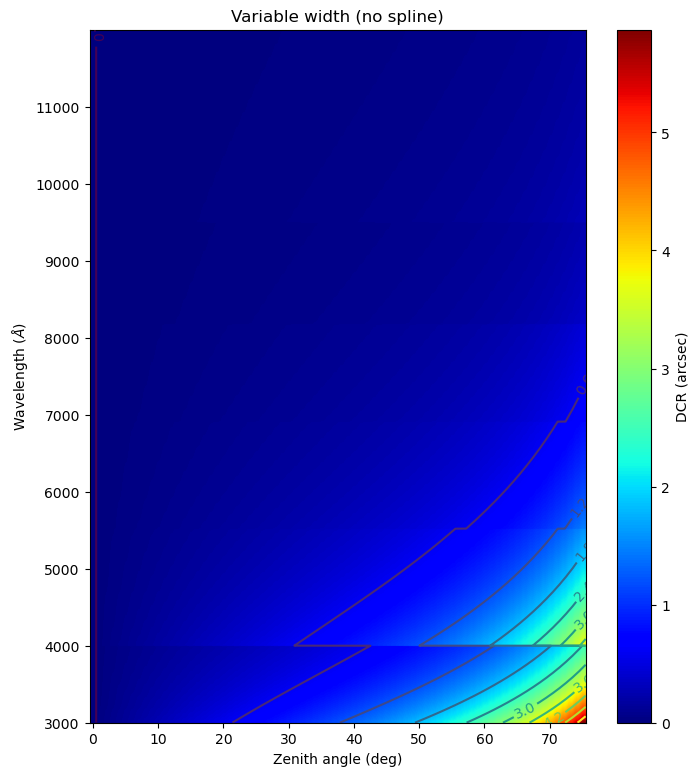

In [57]:
wave = np.arange(3000, 12000, 1)
z = np.arange(0,76,1)
widths = np.array([band_edges_spec[band][1] - band_edges_spec[band][0] for band in filters])
redends = np.array([band_edges_spec[band][0] for band in filters])
laserplot = np.zeros((len(wave), len(z)))

for i, z in enumerate(z):
    width = widths[0]
    for j, w in enumerate(wave):
        
        if w in redends:

            width = widths[np.argwhere(w == redends)][0][0]

        laserplot[j][i] = dcr_offset(w_eff = w, airmass = 1 / np.cos(np.deg2rad(z))) - \
                          dcr_offset(w_eff = w + width, airmass = 1 / np.cos(np.deg2rad(z)))

fig, ax = plt.subplots(figsize=(8,9))
p = ax.imshow(laserplot, cmap='jet', origin='lower',aspect='auto')
c = ax.contour(laserplot, origin='lower', levels=np.arange(0, laserplot.max(), 0.6), aspect='auto')

ax.set_xlabel('Zenith angle (deg)')
ax.set_ylabel(r'Wavelength ($\AA$)')
ax.set_title(r"Variable width (no spline)")
ax.set_yticks(np.arange(0, len(wave), 1000))
ax.set_yticklabels(wave[::1000])
ax.clabel(c, c.levels, inline=True, fontsize=10)

fig.colorbar(p, label=r'DCR (arcsec)')

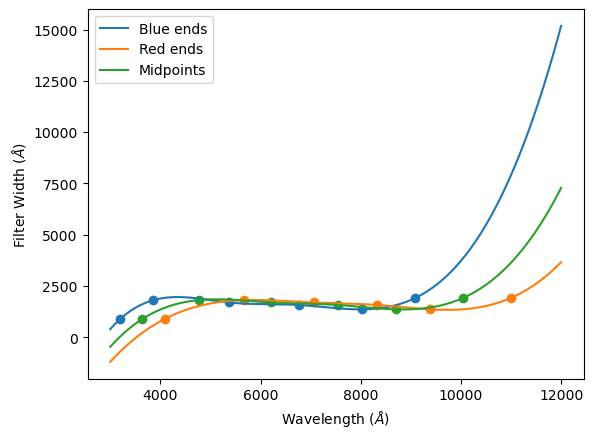

In [58]:
from scipy.interpolate import CubicSpline, Akima1DInterpolator
blueends = np.array([band_edges[band][0] for band in filters])
redends = np.array([band_edges[band][1] for band in filters])
midpts = np.array([(band_edges[band][0] + band_edges[band][1]) / 2 for band in filters])
x1 = blueends
x2 = redends
x3 = midpts
widths = np.array([band_edges[band][1] - band_edges[band][0] for band in filters])
y = widths
xnew = wave

spl1 = CubicSpline(x1, y)
spl2 = CubicSpline(x2, y)
spl3 = CubicSpline(x3, y)

plt.scatter(x1, y)
plt.plot(xnew, spl1(xnew), label='Blue ends')
plt.scatter(x2, y)
plt.plot(xnew, spl2(xnew), label='Red ends')
plt.scatter(x3, y)
plt.plot(xnew, spl3(xnew), label='Midpoints')
plt.xlabel(r'Wavelength $(\AA)$')
plt.ylabel(r'Filter Width $(\AA)$')
plt.legend()

In [59]:
wave[np.where(spl3(xnew) == abs(spl3(xnew)).min())[0][0]]

3187

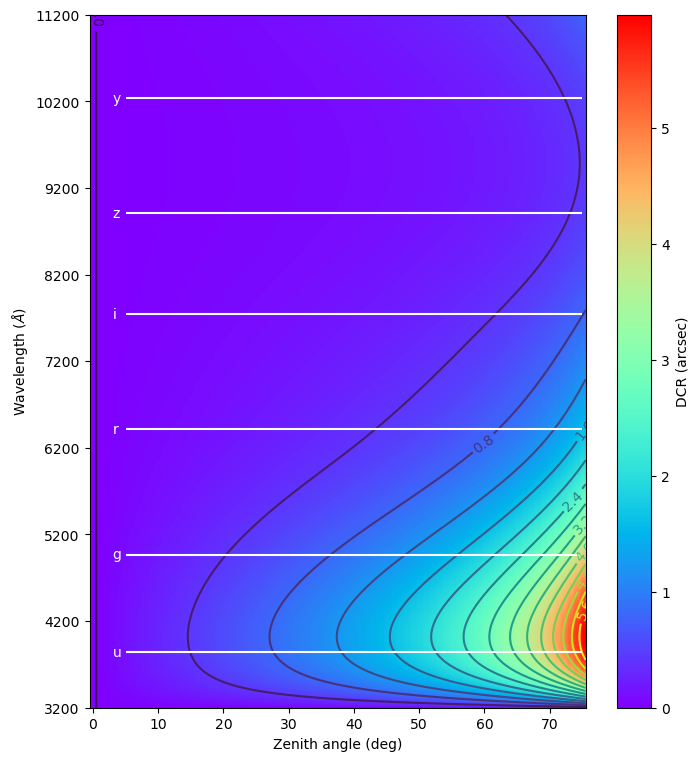

In [61]:
wave = np.arange(3200, 11201, 1)
z = np.arange(0,76,1)
widths = np.array([band_edges[band][1] - band_edges[band][0] for band in filters])
redends = np.array([band_edges[band][1] for band in filters])
blueends = np.array([band_edges[band][0] for band in filters])
midpts = np.array([(band_edges[band][0] + band_edges[band][1]) / 2 for band in filters])
laserplot = np.zeros((len(wave), len(z)))

spl = CubicSpline(midpts, widths)(wave)

for i, z in enumerate(z):
    for j, w in enumerate(wave):
        width = spl[j]
        laserplot[j][i] = dcr_offset(w_eff = w - width / 2, airmass = 1 / np.cos(np.deg2rad(z))) - \
                          dcr_offset(w_eff = w + width / 2, airmass = 1 / np.cos(np.deg2rad(z)))

fig, ax = plt.subplots(figsize=(8,9))
p = ax.imshow(laserplot, cmap='rainbow', origin='lower',aspect='auto')
c = ax.contour(laserplot, origin='lower', levels=np.arange(0, laserplot.max(), 0.4), aspect='auto')

ax.hlines(midpts - 3000, 5, 75, color='white')

for f, pt in zip(filters, midpts):
    ax.text(3, pt - 3000, f, ha='left', va='center', color='white')

ax.set_xlabel('Zenith angle (deg)')
ax.set_ylabel(r'Wavelength ($\AA$)')
#ax.set_title(r"Variable width (with spline)")
ax.set_yticks(np.arange(0, len(wave), 1000))
ax.set_yticklabels(wave[::1000])
ax.clabel(c, c.levels[::2], inline=True, fontsize=10)

fig.colorbar(p, label=r'DCR (arcsec)')
plt.savefig(ROOTDIR + '/Figures/dcrworstcase.png', dpi=300, bbox_inches='tight')

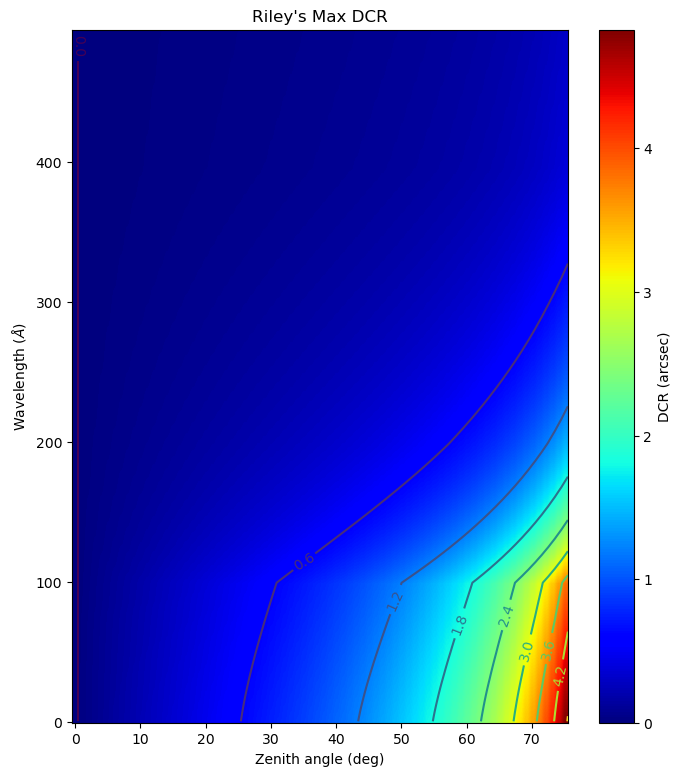

In [62]:
band_edges = band_edges_spec.copy()
nsub = 100
z = np.arange(0,76,1)

a = np.array([[band_edges[band][0] for band in band_edges], [band_edges[band][1] for band in band_edges]])

c = []
for b in range(5):
    c.append(np.linspace(a[:,b], a[:,b + 1], nsub, endpoint=True)[:-1])

c = np.array(c).reshape(495, 2)

laserplot = np.zeros((len(c), len(z)))

for i, za in enumerate(z):

    for j, pair in enumerate(c):

        laserplot[j][i] = dcr_offset(w_eff = pair[0], airmass = 1 / np.cos(np.deg2rad(za))) - \
                          dcr_offset(w_eff = pair[1], airmass = 1 / np.cos(np.deg2rad(za)))
        
fig, ax = plt.subplots(figsize=(8,9))
p = ax.imshow(laserplot, cmap='jet', origin='lower',aspect='auto')
cont = ax.contour(laserplot, origin='lower', levels=np.arange(0, laserplot.max(), 0.6), aspect='auto')

ax.set_xlabel('Zenith angle (deg)')
ax.set_ylabel(r'Wavelength ($\AA$)')
ax.set_title(r"Riley's Max DCR")
ax.clabel(cont, cont.levels, inline=True, fontsize=10)

fig.colorbar(p, label=r'DCR (arcsec)')

## Messing around with Balmer jumps

In [82]:
lines = [3934, 3968, 4101, 4340, 4861]
mdpath = ROOTDIR + quiescent_spectra[quiescent_spectrum].replace('.fits', '_ext.npy')

[<Axes: > <Axes: >]
Quiescent scale factor = 20.760265880373115


(4739.787845733088, 4695.405100288007, 4983.211372731041)

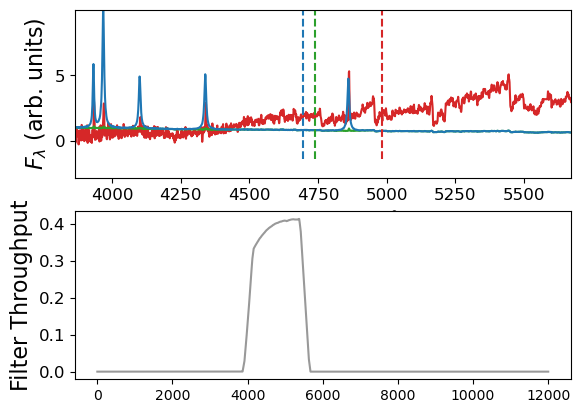

In [83]:
lamb_eff_md('g', temp = 10000, balmer_ratio = 1.0, lorentz_lines=lines, linefrac=[0.1, 0.1], 
            mdpath=mdpath, compplot=True)

In [84]:
lamb_eff_md('g', temp = 12000, balmer_ratio = 1.0, 
            mdpath=mdpath, compplot=True)

4711.585866490831

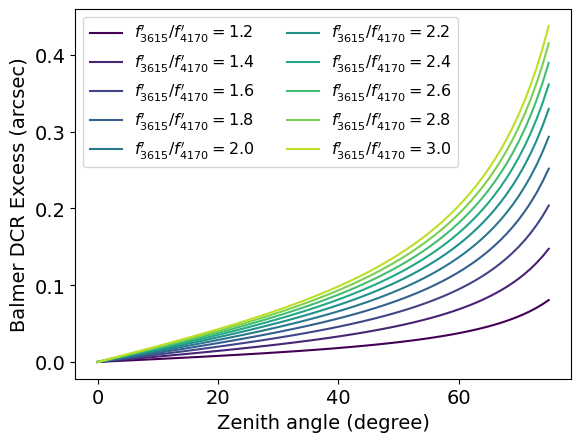

In [85]:
z = np.arange(0,76)
bratio = np.arange(1.2, 3.2, 0.2)
fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis')

for j in range(len(bratio)):
    weff_1 = lamb_eff_md(band='u', temp=10000, balmer_ratio=1.0, mdpath=mdpath)
    weff_2 = lamb_eff_md(band='u', temp=10000, balmer_ratio=bratio[j], mdpath=mdpath)
    ax.plot(z, dcr_offset(weff_2, airmass = 1 / np.cos(np.deg2rad(z))) - dcr_offset(weff_1, airmass = 1 / np.cos(np.deg2rad(z))), 
             label = r'$f_{3615}^{\prime} / f_{4170}^{\prime} = $' + '{}'.format(np.round(bratio[j], decimals=1)), color=cmap(j / len(bratio)))

ax.set_ylabel(r'Balmer DCR Excess (arcsec)', fontsize=14)
ax.set_xlabel('Zenith angle (degree)', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.legend(ncol=2, fontsize=11.5)

plt.savefig('Figures/balmerjump.png', dpi=300, bbox_inches='tight')

In [123]:
castep, hstep = 50,50
lineplot = np.zeros((castep, hstep, 4))
caII = np.linspace(0,0.5,castep)
hII = np.linspace(0,0.5,hstep)

weff_q = lamb_eff_md('g', temp = 0, mdpath=mdpath) #moved outside loop!
for n, Tbb in tqdm(enumerate(np.arange(10000, 50000, 10000))):
    #print(n)
    for i, a in enumerate(caII):
        #print(a)
        for j, b in enumerate(hII):
            #print(b)
            weff_f = lamb_eff_md('g', temp = Tbb, lorentz_lines=[3934, 3968, 4101, 4340, 4861], 
                                 linefrac=[a, b], mdpath=mdpath)[1]
            
            lineplot[i][j][n] = dcr_offset(weff_f, airmass=1.6) - dcr_offset(weff_q, airmass=1.6)
            #print([a, b])

4it [06:39, 99.80s/it]


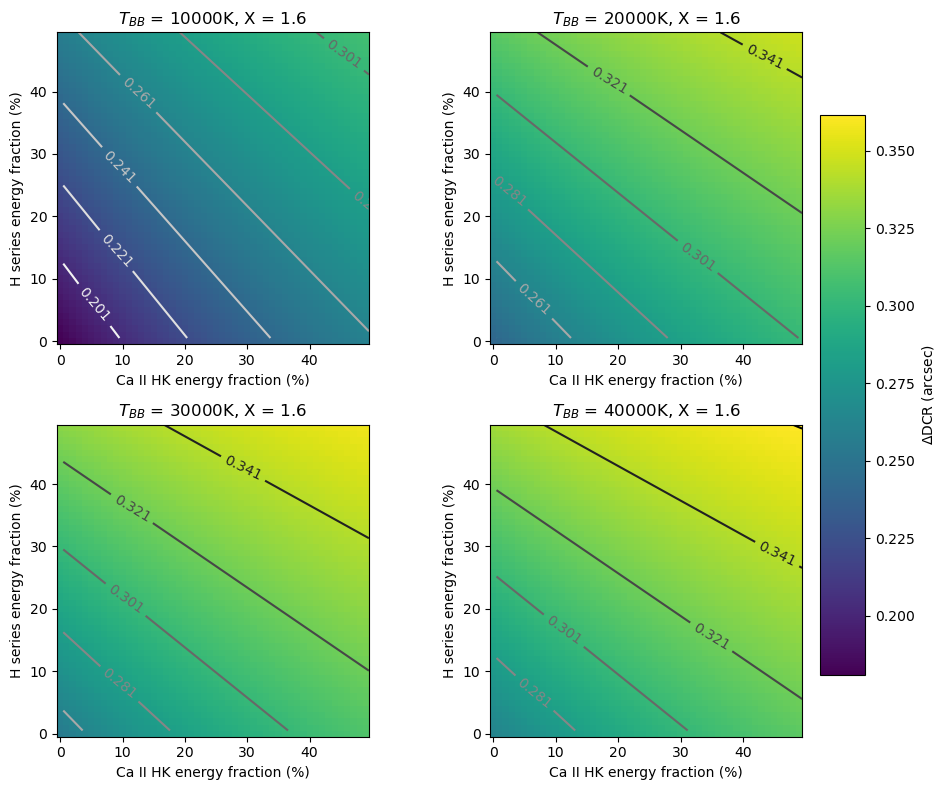

In [124]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,8))   

for n in range(4):
    p = ax.flat[n].imshow(lineplot[:,:,n], clim=(lineplot.min(), lineplot.max()), origin='lower')
    ax.flat[n].set_xlabel('Ca II HK energy fraction (%)')
    ax.flat[n].set_ylabel('H series energy fraction (%)')
    ax.flat[n].set_title(r'$T_{BB}$ = ' + '{}K'.format((n + 1) * 10000) + ', X = 1.6')
    cont = ax.flat[n].contour(lineplot[:,:,n], origin='lower', cmap='Greys', levels=np.arange(lineplot.min(), lineplot.max(), 0.02), aspect='auto')
    ax.flat[n].clabel(cont, cont.levels, inline=True, fontsize=10)

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax, label=r'$\Delta$DCR (arcsec)')
fig.tight_layout()

Fitting Lorenztians to spectra

In [125]:
if4 = pd.read_csv('akspec_if4.csv')
if4.head()

,x,y
0,3864.081316,8.581002e-14
1,3870.478194,9.358301e-14
2,3876.182025,1.081751e-13
3,3878.568278,1.202732e-13
4,3879.647712,1.381172e-13


In [126]:
if4.columns

Index(['x', 'y'], dtype='object')

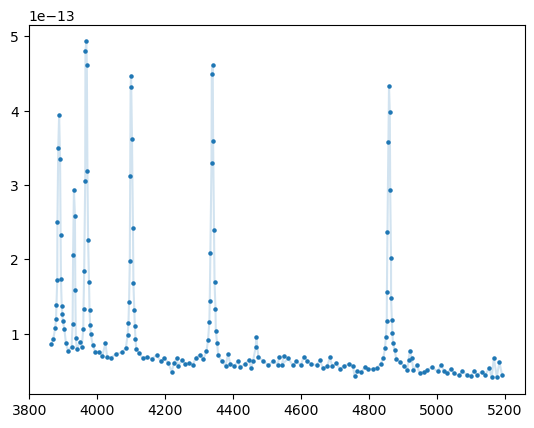

In [127]:
plt.scatter(if4['x'], if4['y'], s=5)
plt.plot(if4['x'], if4['y'], alpha=0.2)

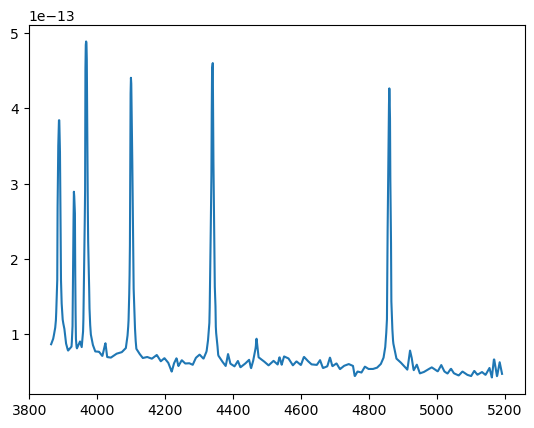

In [128]:
f = interp1d(if4['x'], if4['y'])

x_data = np.arange(if4['x'].min(), if4['x'].max(), 1.0)
y_data = f(x_data)

plt.plot(x_data, y_data)

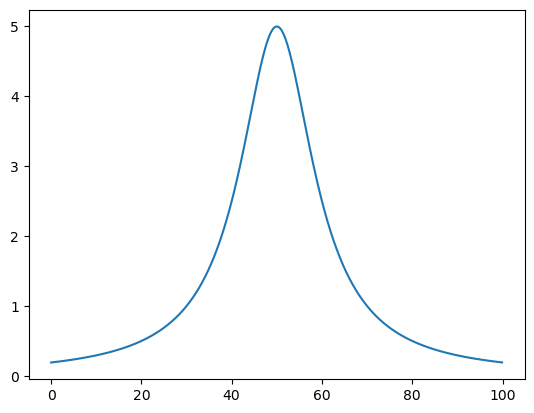

In [129]:
from utils import lorentzian

x = np.arange(0,100,0.1)
y = lorentzian(x, 5.0, 50, 20)

plt.plot(x,y)

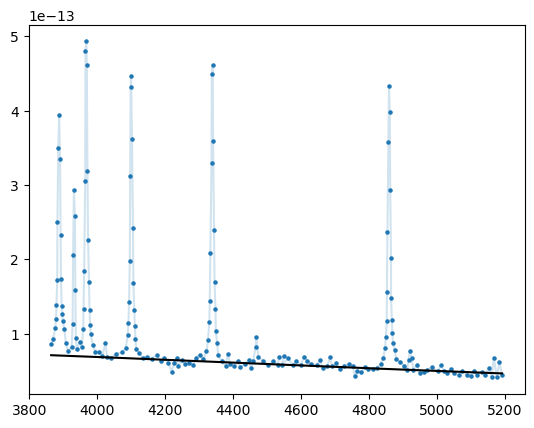

In [130]:
plt.scatter(if4['x'], if4['y'], s=5)
plt.plot(if4['x'], if4['y'], alpha=0.2)

dist = 6.34 * u.pc
Rstar = 0.36 * u.Rsun
bb = BlackBody(temperature=9304*u.K, scale=1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr)

plt.plot(if4['x'], bb(if4['x']) * (2*np.pi*u.sr) * (Rstar.to('cm')**2) / ((dist.to('cm'))**2) * (0.0164 ** 2), c='k')


Fitted parameters: A = 3.8855659160865685e-13, x0 = 4860.04, gamma = 8.02


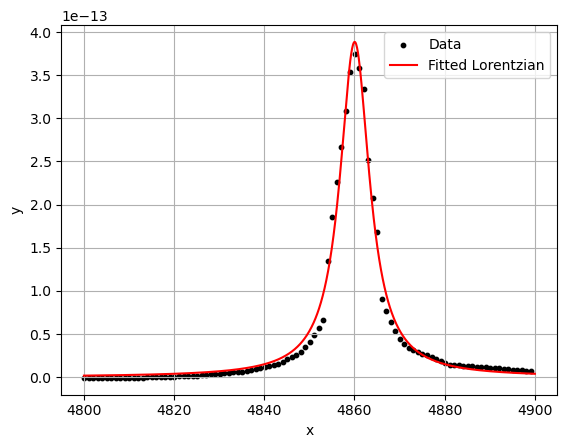

In [131]:
## test fit

dist = 6.34 * u.pc
Rstar = 0.36 * u.Rsun
bb = BlackBody(temperature=9304*u.K, scale=1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr) 

hbeta_x = x_data[(x_data > 4800) * (x_data < 4900)]

bbflux = bb(hbeta_x) * (2*np.pi*u.sr) * (Rstar.to('cm')**2) / ((dist.to('cm'))**2) * (0.0164 ** 2)
hbeta_y = y_data[(x_data > 4800) * (x_data < 4900)] - bbflux.value

def obj(params, x, y):
    A, x0, gamma = params
    return np.sum((lorentzian(x, A, x0, gamma) - y) ** 2)

initial_guess = [1e-13, 4863, 10]

# Perform the minimization
result = minimize(obj, initial_guess, args=(hbeta_x, hbeta_y), bounds=[(0, None), (None, None), (0, None)], method='Nelder-Mead', options = {'gtol':1e-3})

# Extract the fitted parameters
A_fit, x0_fit, gamma_fit = result.x

# Print the results
print(f"Fitted parameters: A = {A_fit}, x0 = {x0_fit:.2f}, gamma = {gamma_fit:.2f}")

plt.scatter(hbeta_x, hbeta_y, label='Data', color='black', s=10)
x_fit = np.linspace(4800, 4900, 1000)
y_fit = lorentzian(x_fit, A_fit, x0_fit, gamma_fit)
plt.plot(x_fit, y_fit, label=f'Fitted Lorentzian', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
linenames = ['Ca II H', 'Ca II K', r'H$\delta$', r'H$\gamma$', r'H$\beta$']

Fitted parameters: A = 2.3955000018337714e-13, x0 = 3931.85, gamma = 5.52


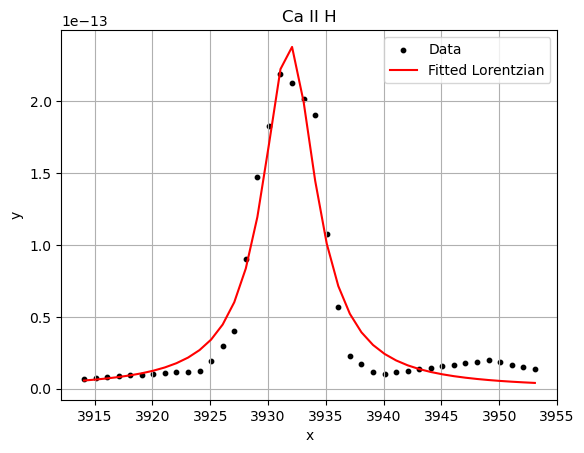

Fitted parameters: A = 4.5223259608283766e-13, x0 = 3967.58, gamma = 7.62


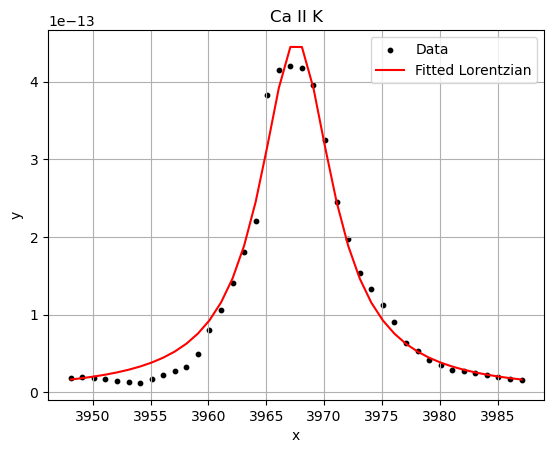

Fitted parameters: A = 3.884269130576187e-13, x0 = 4100.19, gamma = 7.61


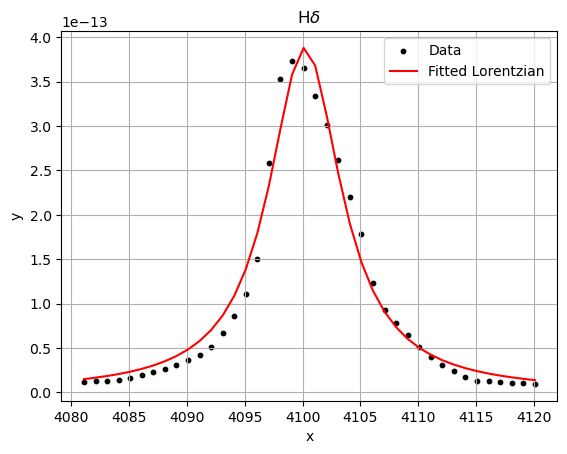

Fitted parameters: A = 4.1020809853775025e-13, x0 = 4339.13, gamma = 8.01


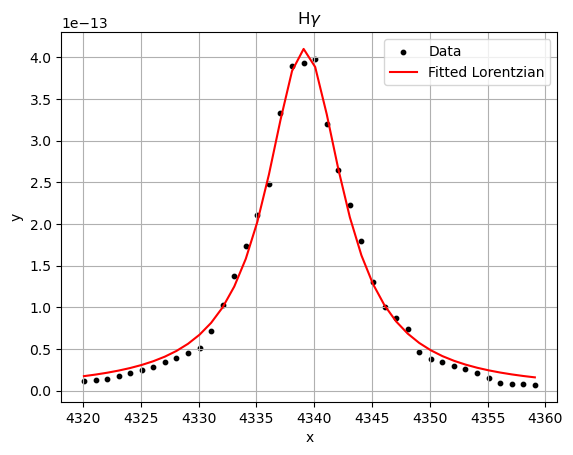

Fitted parameters: A = 3.8839800102911466e-13, x0 = 4860.04, gamma = 8.03


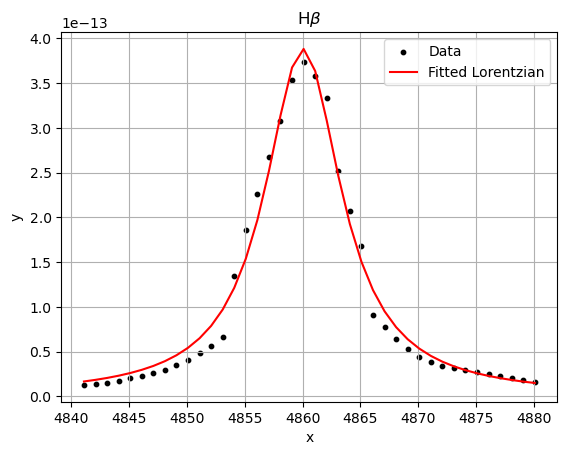

In [133]:
dist = 6.34 * u.pc
Rstar = 0.36 * u.Rsun
bb = BlackBody(temperature=9304*u.K, scale=1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr) 

linedict = {}

for i, line in enumerate(lines):

    window = np.where((x_data > line - 20) * (x_data < line + 20))[0]
    line_x = x_data[window]
    bbflux = bb(line_x) * (2*np.pi*u.sr) * (Rstar.to('cm')**2) / ((dist.to('cm'))**2) * (0.0164 ** 2)
    line_y = y_data[window] - bbflux.value
  
    def obj(params, x, y):
        A, x0, gamma = params
        return np.sum((lorentzian(x, A, x0, gamma) - y) ** 2)

    initial_guess = [1e-13, 4863, 10]

    # Perform the minimization
    result = minimize(obj, initial_guess, args=(line_x, line_y), bounds=[(0, None), (None, None), (0, None)], method='Nelder-Mead', options = {'gtol':1e-2})

    # Extract the fitted parameters
    A_fit, x0_fit, gamma_fit = result.x

    # Print the results
    print(f"Fitted parameters: A = {A_fit}, x0 = {x0_fit:.2f}, gamma = {gamma_fit:.2f}")

    linedict[linenames[i]] = result.x

    plt.scatter(line_x, line_y, label='Data', color='black', s=10)
    x_fit = line_x
    y_fit = lorentzian(x_fit, A_fit, x0_fit, gamma_fit)
    plt.plot(x_fit, y_fit, label=f'Fitted Lorentzian', color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(linenames[i])
    plt.legend()
    plt.grid(True)
    plt.show()

In [134]:
linedict

{'Ca II H': array([2.39550000e-13, 3.93184712e+03, 5.51710509e+00]),
 'Ca II K': array([4.52232596e-13, 3.96757926e+03, 7.61958415e+00]),
 'H$\\delta$': array([3.88426913e-13, 4.10018988e+03, 7.61420211e+00]),
 'H$\\gamma$': array([4.10208099e-13, 4.33913340e+03, 8.00815074e+00]),
 'H$\\beta$': array([3.88398001e-13, 4.86003526e+03, 8.02575104e+00])}

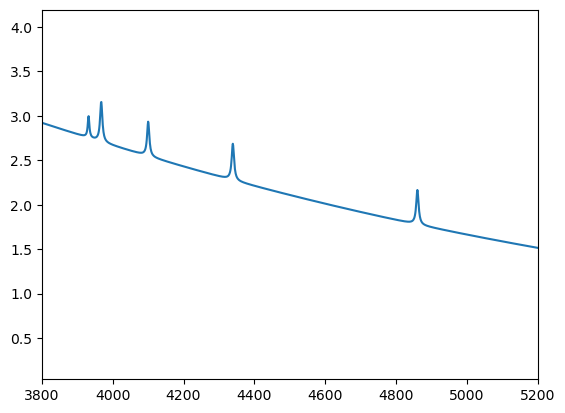

In [135]:
bb = BlackBody(temperature=12000*u.K, scale=1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr)

wav = np.arange(3000, 10000)

plx = 10.27
dist = 1000 / plx * u.pc

# Star flux
flux = bb(wav) * (2*np.pi*u.sr) * (Rstar.to('cm') **2) / ((dist.to('cm'))**2)

for line in linenames:
    flux += lorentzian(wav, *linedict[line]) * u.erg/u.s/u.cm/u.cm/u.AA 

plt.figure()
plt.plot(wav, flux * 1e12, c='C0')
plt.xlim(3800, 5200)
plt.show()

In [136]:
x = np.arange(0,50,0.1)

l1 = lorentzian(x, 5, 25, 5)
l2 = lorentzian(x, 10, 25, 5)
l3 = lorentzian(x, 5, 25, 5) * 2
print(l1.sum(), l2.sum(), l3.sum())

367.78185322306666 735.5637064461333 735.5637064461333


sum under lorentzian is proportional to amplitude -> FIX scaling its broke af

Quiescent scale factor = 15.072302657376943


(4761.005314905431, 4714.217924880651, 4983.211372731041)

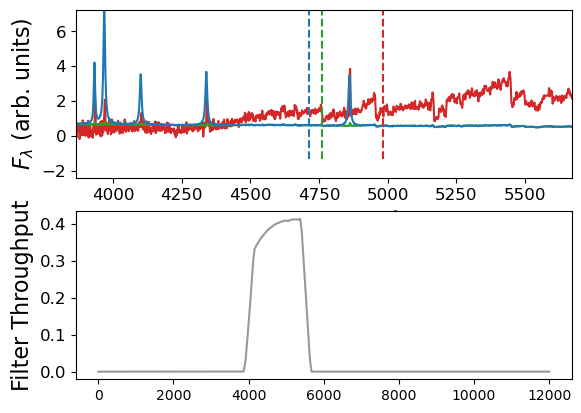

In [137]:
lamb_eff_md(band = 'g', temp=9000, mdpath = mdpath, lorentz_lines=True, linefrac=[0.1, 0.1], compplot=True)

In [ ]:
linenames